## Bloque I
Descomprimir el csv en formato gz

In [1052]:
"""  
Importación de ficheros de AIRBNB. Preprocesado y cargado a la base de datos 

Obtenemos los datos desde https://insideairbnb.com/get-the-data/

Podríamos hacer scraping, obtener la fecha de la última actualización de Madrid y generar el enlace para descargarlo, pero no es necesario por que se actualiza cada mucho tiempo y no es necesario tener la última versión. Podemos cambiar la info procesable en la carpeta data manualmente.

"""
import os
import pandas as pd
import numpy as np
import datetime
#from config_bd import *
import requests
import sys
import gzip
import shutil
import matplotlib.pyplot as plt


In [1053]:
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import cross_val_score


In [1054]:

# DATA_DIR = os.path.join('data')
# # DATA_DIR = os.path.join(os.path.dirname(__file__), 'data')
# TEMP_DIR = os.path.join(DATA_DIR, 'TEMP')


# """ Comprobamos que existe el directorio de datos """

# if not os.path.exists(DATA_DIR):
#     print(f"El directorio {DATA_DIR} no existe. No es posible continuar...")
#     sys.exit()

# """ Descomprimimos el archivo de calendario """

# if not os.path.exists(TEMP_DIR):
#     os.makedirs(TEMP_DIR)


# gz_file_path = os.path.join(DATA_DIR, 'listings.csv.gz')
# output_file_path = os.path.join(TEMP_DIR, os.path.splitext(os.path.basename(gz_file_path))[0])

# if os.path.exists(gz_file_path):
#     try:
#         with gzip.open(gz_file_path, 'rb') as f_in:
#             with open(output_file_path, 'wb') as f_out:
#                 shutil.copyfileobj(f_in, f_out)
#         print(f"Archivo {gz_file_path} descomprimido como {output_file_path}")
#     except Exception as e:
#         print(f"Error al descomprimir el archivo {gz_file_path}: {e}")
#         sys.exit()
# else:
#     print(f"El archivo {gz_file_path} no existe. No es posible continuar...")
#     sys.exit()


In [1055]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

## Import Data
Carga del csv de detalle completo en pandas. Cambios de tipos e imputación

In [1056]:
output_file_path = './data/listings.csv'

In [1057]:
df = pd.read_csv(output_file_path, low_memory=False)

In [1058]:
df

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,21853,https://www.airbnb.com/rooms/21853,20250305023340,2025-03-11,city scrape,Bright and airy room,We have a quiet and sunny room with a good vie...,We live in a leafy neighbourhood with plenty o...,https://a0.muscache.com/pictures/68483181/87bc...,83531,...,4.82,4.21,4.67,NaN,f,2,0,2,0,0.26
1,30320,https://www.airbnb.com/rooms/30320,20250305023340,2025-03-10,previous scrape,Great Vacational Apartments,NaN,NaN,https://a0.muscache.com/pictures/336868/f67409...,130907,...,4.78,4.90,4.69,NaN,f,3,3,0,0,0.96
2,30959,https://www.airbnb.com/rooms/30959,20250305023340,2025-03-10,previous scrape,Beautiful loft in Madrid Center,Beautiful Loft 60m2 size just in the historica...,NaN,https://a0.muscache.com/pictures/78173471/835e...,132883,...,4.63,4.88,4.25,NaN,f,1,1,0,0,0.07
3,40916,https://www.airbnb.com/rooms/40916,20250305023340,2025-03-10,previous scrape,Holiday Apartment Madrid Center,NaN,NaN,https://a0.muscache.com/pictures/336736/c3b486...,130907,...,4.79,4.88,4.55,NaN,f,3,3,0,0,0.28
4,62423,https://www.airbnb.com/rooms/62423,20250305023340,2025-03-12,city scrape,MAGIC ARTISTIC HOUSE IN THE CENTER OF MADRID,INCREDIBLE HOME OF AN ARTIST SURROUNDED BY PAI...,DISTRICT WITH VERY GOOD VIBES IN THE MIDDLE OF...,https://a0.muscache.com/pictures/miso/Hosting-...,303845,...,4.85,4.97,4.58,NaN,f,3,1,2,0,2.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25283,1368985680426539467,https://www.airbnb.com/rooms/1368985680426539467,20250305023340,2025-03-12,city scrape,Acogedor y nuevo ático con gran terraza (B),"Cozy penthouse floor with large terrace, locat...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,20803102,...,NaN,NaN,NaN,NaN,f,3,3,0,0,NaN
25284,1368986418960986344,https://www.airbnb.com/rooms/1368986418960986344,20250305023340,2025-03-05,city scrape,Elegante apartamento en Madrid!,Have fun with the whole family at this stylish...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,52530675,...,NaN,NaN,NaN,NaN,f,45,45,0,0,NaN
25285,1368991577357063431,https://www.airbnb.com/rooms/1368991577357063431,20250305023340,2025-03-10,city scrape,Tropical apartment Madrid,Get away from routine at this unique and relax...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,52530675,...,NaN,NaN,NaN,NaN,f,45,45,0,0,NaN
25286,1369034696848967860,https://www.airbnb.com/rooms/1369034696848967860,20250305023340,2025-03-07,city scrape,"Cama 1 de 04, no es hinchable.",Enjoy the comfort and tranquility of this home.,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,543251626,...,NaN,NaN,NaN,NaN,f,4,0,0,4,NaN


In [1059]:
df.shape

(25288, 79)

Eliminamos campos innecesarios que a priori no nos sirven

In [1060]:
df = df.drop(columns=['scrape_id','last_scraped','source','neighborhood_overview','host_id','host_url','host_name','host_since','host_location','host_response_time','host_response_rate','host_acceptance_rate','host_is_superhost','host_thumbnail_url','host_picture_url','host_listings_count','host_total_listings_count','host_verifications','host_has_profile_pic','host_identity_verified','neighbourhood','bathrooms_text','beds','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','has_availability','calendar_last_scraped','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','availability_eoy','number_of_reviews_ly','first_review','last_review','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','license','instant_bookable','calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month','host_about','host_neighbourhood','calendar_updated','availability_30','availability_60','availability_90','availability_365','picture_url'])

Eliminamos las habitaciones, casas compartidas, hoteles, etc, solo queremos VIVIENDAS COMPLETAS

In [1061]:
# df['property_type'].value_counts()
# df['room_type'].value_counts()

df = df[df['room_type']== 'Entire home/apt'].copy()
df['room_type'].value_counts()

room_type
Entire home/apt    16805
Name: count, dtype: int64

conversión de tipos

In [1062]:
df['accommodates'] = df['accommodates'].astype(int)
df['bathrooms'] = df['bathrooms'].replace([np.inf,-np.inf],np.nan).fillna(0).astype(int)
df['bedrooms'] = df['bedrooms'].replace([np.inf,-np.inf],np.nan).fillna(0).astype(int)
df['price'] = df['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
df['minimum_nights'] = df['minimum_nights'].astype(int)
df['maximum_nights'] = df['maximum_nights'].astype(int)
df['estimated_occupancy_l365d'] = df['estimated_occupancy_l365d'].astype(int)

imputamos una habitación y un baño cuando esta información no está rellena, asumiendo que habiendo retirado las propiedades compartidas, podemos interpretar que los estudios, lofts, etc todos van a tener al menos una habitación y baño o equivalente. (Sofá cama, etc).

*También se podría imputar las habitaciones dividiendo los "acommodates" entre dos pero creo que este método es más conservador.*

In [1063]:
df

,id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,amenities,price,minimum_nights,maximum_nights,estimated_occupancy_l365d,estimated_revenue_l365d
1,30320,https://www.airbnb.com/rooms/30320,Great Vacational Apartments,NaN,Sol,Centro,40.414760,-3.704180,Entire rental unit,Entire home/apt,2,0,1,"[""Kitchen"", ""Air conditioning"", ""Elevator"", ""T...",NaN,5,180,0,NaN
2,30959,https://www.airbnb.com/rooms/30959,Beautiful loft in Madrid Center,Beautiful Loft 60m2 size just in the historica...,Embajadores,Centro,40.412590,-3.701050,Entire loft,Entire home/apt,2,0,1,"[""Shampoo"", ""Smoking allowed"", ""Pets allowed"",...",NaN,3,730,0,NaN
3,40916,https://www.airbnb.com/rooms/40916,Holiday Apartment Madrid Center,NaN,Universidad,Centro,40.422470,-3.705770,Entire rental unit,Entire home/apt,3,0,1,"[""Pets allowed"", ""Kitchen"", ""TV"", ""Air conditi...",NaN,5,180,0,NaN
5,70059,https://www.airbnb.com/rooms/70059,Tu hogar en centro de Madrid.,"Very nice, cozy and bright, right in the cente...",Universidad,Centro,40.423810,-3.710380,Entire rental unit,Entire home/apt,2,1,1,"[""Paid parking off premises"", ""Window AC unit""...",66.0,15,365,0,0.0
6,70310,https://www.airbnb.com/rooms/70310,"Heart of Malasaña Cozy, Quiet & Sunny Apartment",Cozy Apartment in great location in the center...,Universidad,Centro,40.422520,-3.702500,Entire rental unit,Entire home/apt,2,1,1,"[""Portable fans"", ""Paid parking off premises"",...",89.0,30,360,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25281,1368974630547284843,https://www.airbnb.com/rooms/1368974630547284843,Coqueto estudio en tetuan!,Disconnect from the routine in this charming a...,Valdeacederas,Tetuán,40.464951,-3.704578,Entire rental unit,Entire home/apt,2,1,1,"[""Air conditioning"", ""Pets allowed"", ""Wifi"", ""...",67.0,5,365,0,0.0
25282,1368981094706864086,https://www.airbnb.com/rooms/1368981094706864086,Bonito estudio en Tetuán!,Get away from routine at this unique and relax...,Valdeacederas,Tetuán,40.468355,-3.706939,Entire rental unit,Entire home/apt,2,1,1,"[""Air conditioning"", ""Pets allowed"", ""Wifi"", ""...",63.0,5,365,0,0.0
25283,1368985680426539467,https://www.airbnb.com/rooms/1368985680426539467,Acogedor y nuevo ático con gran terraza (B),"Cozy penthouse floor with large terrace, locat...",Canillas,Hortaleza,40.464110,-3.647130,Entire rental unit,Entire home/apt,3,1,1,"[""Cleaning available during stay"", ""Wifi"", ""Wi...",103.0,2,365,0,0.0
25284,1368986418960986344,https://www.airbnb.com/rooms/1368986418960986344,Elegante apartamento en Madrid!,Have fun with the whole family at this stylish...,San Isidro,Carabanchel,40.395983,-3.730953,Entire rental unit,Entire home/apt,5,1,2,"[""Pets allowed"", ""Kitchen"", ""TV"", ""Air conditi...",100.0,5,365,0,0.0


In [1064]:
# df[(df['bathrooms'] == 0)& (df['bedrooms']==0)]
df['bathrooms'] = df['bathrooms'].replace(0,1)
df['bedrooms'] = df['bedrooms'].replace(0,1)

In [1065]:
df = df.rename(columns={'id':'property_id'})

In [1066]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16805 entries, 1 to 25285
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   16805 non-null  int64  
 1   listing_url                   16805 non-null  object 
 2   name                          16805 non-null  object 
 3   description                   16344 non-null  object 
 4   neighbourhood_cleansed        16805 non-null  object 
 5   neighbourhood_group_cleansed  16805 non-null  object 
 6   latitude                      16805 non-null  float64
 7   longitude                     16805 non-null  float64
 8   property_type                 16805 non-null  object 
 9   room_type                     16805 non-null  object 
 10  accommodates                  16805 non-null  int64  
 11  bathrooms                     16805 non-null  int64  
 12  bedrooms                      16805 non-null  int64  
 13  amenit

#### Data Import of Rentas Ayto Madrid

In [1067]:
#Import data from Ayto de Madrid, rentas
df_rentas = pd.read_csv('../ayto_madrid/Datos_Rentas_Madrid_2022.csv',delimiter=";")
df_rentas.head()

,Distrito,Renta neta media por persona,Renta neta media por hogar,Media de la renta neta por unidad de consumo,Mediana de la renta neta por unidad de consumo,Renta bruta media por persona,Renta media bruta por hogar
0,01. Centro,20.587,41.059,28.500,22.05,27.030,53.908
1,02. Arganzuela,21.383,49.236,31.038,28.35,27.431,63.160
2,03. Retiro,25.407,60.762,37.916,31.85,33.396,79.868
3,04. Salamanca,28.140,64.925,42.592,31.15,38.751,89.407
4,05. Chamartín,30.506,74.842,47.564,34.65,42.678,104.706


In [1068]:
df_rentas.dtypes

Distrito                                           object
Renta neta media por persona                      float64
Renta neta media por hogar                        float64
Media de la renta neta por unidad de consumo      float64
Mediana de la renta neta por unidad de consumo    float64
Renta bruta media por persona                     float64
Renta media bruta por hogar                       float64
dtype: object

In [1069]:
for col in df_rentas.select_dtypes(include='float'):
    df_rentas[col] = df_rentas[col].apply(lambda x: x * 1000)

df_rentas.head()


,Distrito,Renta neta media por persona,Renta neta media por hogar,Media de la renta neta por unidad de consumo,Mediana de la renta neta por unidad de consumo,Renta bruta media por persona,Renta media bruta por hogar
0,01. Centro,20587.0,41059.0,28500.0,22050.0,27030.0,53908.0
1,02. Arganzuela,21383.0,49236.0,31038.0,28350.0,27431.0,63160.0
2,03. Retiro,25407.0,60762.0,37916.0,31850.0,33396.0,79868.0
3,04. Salamanca,28140.0,64925.0,42592.0,31150.0,38751.0,89407.0
4,05. Chamartín,30506.0,74842.0,47564.0,34650.0,42678.0,104706.0


In [1070]:
df['neighbourhood_group_cleansed'].unique()

array(['Centro', 'Salamanca', 'Arganzuela', 'Fuencarral - El Pardo',
       'Chamberí', 'Chamartín', 'Carabanchel', 'Puente de Vallecas',
       'Hortaleza', 'Moncloa - Aravaca', 'Tetuán', 'Retiro',
       'San Blas - Canillejas', 'Barajas', 'Moratalaz', 'Ciudad Lineal',
       'Villaverde', 'Latina', 'Vicálvaro', 'Villa de Vallecas', 'Usera'],
      dtype=object)

In [1071]:
df_rentas['Distrito'].unique()

array(['01. Centro', '02. Arganzuela', '03. Retiro', '04. Salamanca',
       '05. Chamartín', '06. Tetuán', '07. Chamberí',
       '08. Fuencarral-El Pardo', '09. Moncloa-Aravaca', '10. Latina',
       '11. Carabanchel', '12. Usera', '13. Puente de Vallecas',
       '14. Moratalaz', '15. Ciudad Lineal', '16. Hortaleza',
       '17. Villaverde', '18. Villa de Vallecas', '19. Vicálvaro',
       '20. San Blas-Canillejas', '21. Barajas'], dtype=object)

In [1072]:
df_rentas['Distrito'] = df_rentas['Distrito'].str[4:]
df_rentas['Distrito'] = df_rentas['Distrito'].apply(lambda x: x.replace('-', ' - ') if '-' in x else x)
df_rentas.head(21)


,Distrito,Renta neta media por persona,Renta neta media por hogar,Media de la renta neta por unidad de consumo,Mediana de la renta neta por unidad de consumo,Renta bruta media por persona,Renta media bruta por hogar
0,Centro,20587.0,41059.0,28500.0,22050.0,27030.0,53908.0
1,Arganzuela,21383.0,49236.0,31038.0,28350.0,27431.0,63160.0
2,Retiro,25407.0,60762.0,37916.0,31850.0,33396.0,79868.0
3,Salamanca,28140.0,64925.0,42592.0,31150.0,38751.0,89407.0
4,Chamartín,30506.0,74842.0,47564.0,34650.0,42678.0,104706.0
5,Tetuán,18062.0,42465.0,25955.0,20650.0,22890.0,53816.0
6,Chamberí,27076.0,60032.0,40145.0,31150.0,36934.0,81889.0
7,Fuencarral - El Pardo,21947.0,58214.0,34241.0,28350.0,28798.0,76386.0
8,Moncloa - Aravaca,26694.0,68238.0,41666.0,30450.0,36592.0,93541.0
9,Latina,14375.0,35669.0,20833.0,18550.0,17267.0,42843.0


In [1073]:
print(sorted(df['neighbourhood_group_cleansed'].unique()))
print(sorted(df_rentas['Distrito'].unique()))

['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín', 'Chamberí', 'Ciudad Lineal', 'Fuencarral - El Pardo', 'Hortaleza', 'Latina', 'Moncloa - Aravaca', 'Moratalaz', 'Puente de Vallecas', 'Retiro', 'Salamanca', 'San Blas - Canillejas', 'Tetuán', 'Usera', 'Vicálvaro', 'Villa de Vallecas', 'Villaverde']
['Arganzuela', 'Barajas', 'Carabanchel', 'Centro', 'Chamartín', 'Chamberí', 'Ciudad Lineal', 'Fuencarral - El Pardo', 'Hortaleza', 'Latina', 'Moncloa - Aravaca', 'Moratalaz', 'Puente de Vallecas', 'Retiro', 'Salamanca', 'San Blas - Canillejas', 'Tetuán', 'Usera', 'Vicálvaro', 'Villa de Vallecas', 'Villaverde']


## Functions

In [1074]:
from xgboost import XGBRegressor 

models = {"lr":linear_model.LinearRegression(),
          "ridge":linear_model.Ridge(alpha=0),
          "lasso":linear_model.Lasso(),
          "SGD":linear_model.SGDRegressor(),
          "HuberRegressor":linear_model.HuberRegressor(),
          "Elastic":linear_model.ElasticNet(),
          "XGBRegressor":XGBRegressor()}


def get_results(X_train, y_train, X_test, y_test ):
    metrics_analysis = []
    for m, model in tqdm(models.items()):
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)

        mse = metrics.mean_squared_error(y_test, y_test_pred)
        rmse = np.sqrt(mse)
        mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
        r2 = metrics.r2_score(y_test, y_test_pred)

        metrics_ = pd.Series(name=m, data={"r2": r2, "mse": mse, "rmse": rmse, "mape": mape})
        metrics_analysis.append(metrics_)
    return pd.DataFrame(metrics_analysis)


df_rentas['renta_bin'] = pd.cut(
    df_rentas['Renta neta media por hogar'].sort_values(),
    bins=5,
    labels=['muy_bajo','bajo','medio','alto','muy_alto'],
    include_lowest=True
)
df_rentas[['Distrito', 'Renta neta media por hogar', 'renta_bin']]


def get_renta_bin(distrito:str):
    # Busca el distrito en df_rentas y devuelve el valor de 'renta_bin'
    row = df_rentas[df_rentas['Distrito'] == distrito]
    if not row.empty:
        return row['renta_bin'].values[0]
    else:
        return None
    

## Funciones para calcular distancia minima a la estacion del metro
from math import radians, sin, cos, sqrt, atan2

def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of the Earth in kilometers
    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c


def get_nearest_metro_distance(row, df_metro):
    min_distance = float('inf')
    for _, metro_row in df_metro.iterrows():
        distance = haversine(row['longitude'], row['latitude'], metro_row['stop_lon'], metro_row['stop_lat'])
        if distance < min_distance:
            min_distance = distance
    return min_distance
#####

## Understand Data, Get More Data and Clean data
Importamos a la base de datos. 
**Requiere haber creado la tabla** <code>01_CREATE TABLE bnb_property.sql</code>

In [1075]:
#from config_bd import get_connection

In [1076]:
#df.to_csv(os.path.join(TEMP_DIR,'transform_listings.csv'), index=False)

In [1077]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16805 entries, 1 to 25285
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   property_id                   16805 non-null  int64  
 1   listing_url                   16805 non-null  object 
 2   name                          16805 non-null  object 
 3   description                   16344 non-null  object 
 4   neighbourhood_cleansed        16805 non-null  object 
 5   neighbourhood_group_cleansed  16805 non-null  object 
 6   latitude                      16805 non-null  float64
 7   longitude                     16805 non-null  float64
 8   property_type                 16805 non-null  object 
 9   room_type                     16805 non-null  object 
 10  accommodates                  16805 non-null  int64  
 11  bathrooms                     16805 non-null  int64  
 12  bedrooms                      16805 non-null  int64  
 13  amenit

### Property type and room_type

Filter to consider only the property type that correct

In [1078]:
df["property_type"].value_counts()

property_type
Entire rental unit           14881
Entire condo                   549
Entire loft                    512
Entire home                    356
Entire serviced apartment      322
Entire guesthouse               23
Entire guest suite              22
Tiny home                       22
Entire place                    21
Entire vacation home            20
Camper/RV                       16
Entire townhouse                15
Casa particular                 10
Entire villa                     8
Entire chalet                    7
Entire home/apt                  5
Room in aparthotel               4
Floor                            4
Entire cabin                     3
Religious building               2
Hut                              1
Entire bungalow                  1
Yurt                             1
Name: count, dtype: int64

Anteriormente seleccionnado los registros con room_type =  'Entire home/apt'.
Ahora quitamos los registros que no se corresponden a una vivienda en funcion del room_type

In [1079]:
property_types_to_remove = ['Camper/RV', 'Room in aparthotel', 'Entire cabin','Hut','Yurt','Entire Bungalow']
df = df[~df['property_type'].isin(property_types_to_remove)].copy()

In [1080]:
df['property_type'].value_counts()

property_type
Entire rental unit           14881
Entire condo                   549
Entire loft                    512
Entire home                    356
Entire serviced apartment      322
Entire guesthouse               23
Tiny home                       22
Entire guest suite              22
Entire place                    21
Entire vacation home            20
Entire townhouse                15
Casa particular                 10
Entire villa                     8
Entire chalet                    7
Entire home/apt                  5
Floor                            4
Religious building               2
Entire bungalow                  1
Name: count, dtype: int64

In [1081]:
df[['accommodates','bedrooms','bathrooms']]

,accommodates,bedrooms,bathrooms
1,2,1,1
2,2,1,1
3,3,1,1
5,2,1,1
6,2,1,1
...,...,...,...
25281,2,1,1
25282,2,1,1
25283,3,1,1
25284,5,2,1


### Amenities

In [1082]:
import ast

def get_all_amenities(data):
    """
    Devuelve un set con todos los amenities únicos presentes en la columna 'amenities' del DataFrame.
    """
    all_amenities = set()
    for amenities_str in data["amenities"]:
        try:
            amenities_list = ast.literal_eval(amenities_str)
            all_amenities.update(amenities_list)
        except Exception:
            continue
    return all_amenities

In [1083]:
amenities = get_all_amenities(df)

In [1084]:
len(amenities)

2881

In [1085]:
# df['aire'] = df['amenities'].apply(lambda x: 1 if '"Air conditioning"' in x else 0)
# df['garaje'] = df['amenities'].apply(lambda x: 1 if 'free parking' in x.lower() else 0)
# df['ascensor'] = df['amenities'].apply(lambda x: 1 if '"Elevator"' in x else 0)

In [1086]:
amentities_exclude = ['condition','pool','BBQ','sauna','conditioner','Exercise equipment','Paid Parking','sound system','Housekeeping','book','amazon','soap','shampoo','hair dryer','iron','washer','dryer','TV','internet','wifi','kitchen','microwave','refrigerator','stove','oven','dishwasher','coffee maker','toaster']

In [1087]:
for exclude_amenity in amentities_exclude:
     amenities = [value for value in amenities if str.lower(exclude_amenity) not in str.lower(value)]


In [1088]:
len(amenities)

245

In [1089]:
amenities

['AC - split type ductless system',
 'Paid crib - available upon request',
 'Coffee',
 'Ceiling fan',
 'Game console: Xbox One',
 'Building staff',
 'Window guards',
 'Property manager',
 'Standalone high chair - always at the listing',
 'Movie theater',
 'Garden view',
 'Freezer',
 'Clothing storage: walk-in closet and wardrobe',
 'Board games',
 'Shared gym nearby',
 'Bay view',
 'Baby safety gates',
 'Paid resort access',
 'Shared backyard – Not fully fenced',
 'Clamp on table seat high chair',
 'Desert view',
 'Harbor view',
 'Game console',
 'City skyline view',
 'Game console: PS5',
 'Valley view',
 'Barbecue utensils',
 'Backyard - Fully fenced',
 'Game console: PS3',
 'Paid standalone high chair - available upon request',
 'Clothing storage: walk-in closet and dresser',
 'Golf course view',
 'High chair - available upon request',
 'Safe',
 'EV charger',
 'Booster seat high chair',
 'Private backyard – Not fully fenced',
 'Lake access',
 'Gym in building',
 'Outdoor playground',

##### Heating

In [1090]:
[value for value in amenities if 'heating' in str.lower(value)]

['Heating - split type ductless system',
 'Radiant heating',
 'Heating',
 'Central heating']

In [1091]:
df['calefaccion'] = df['amenities'].apply(lambda x: 1 if 'heating' in x.lower() else 0)

In [1092]:
df['calefaccion'].value_counts()

calefaccion
1    14459
0     2321
Name: count, dtype: int64

##### Pool

In [1093]:
[value for value in amenities if ('pool' in str.lower(value)) and ('whirlpool' not in str.lower(value)) and ('whirpool' not in str.lower(value))]

[]

- Pool

In [1094]:
df['pool'] = df['amenities'].apply(lambda x: 1 if ('pool' in str.lower(x)) and ('whirlpool' not in str.lower(x)) and ('whirpool' not in str.lower(x)) else 0)

In [1095]:
df['pool'].value_counts()

pool
0    16022
1      758
Name: count, dtype: int64

##### Parking

In [1096]:
[value for value in amenities if 'free parking' in str.lower(value)]

['Free parking garage on premises – 81 spaces',
 'Free parking garage on premises – 1 space',
 'Free parking on premises – 1 space',
 'Free parking garage on premises – 17 spaces',
 'Free parking garage on premises – 2 spaces',
 'Free parking garage on premises – 51 spaces',
 'Free parking on premises',
 'Free parking garage on premises',
 'Free parking garage on premises – 45 spaces']

In [1097]:
df['garaje'] = df['amenities'].apply(lambda x: 1 if 'free parking' in x.lower() else 0)

In [1098]:
df['garaje'].value_counts()

garaje
0    15842
1      938
Name: count, dtype: int64

##### Air conditioning

In [1099]:
[value for value in amenities if 'air conditi' in str.lower(value)]

[]

In [1100]:
df['aire_acondicionado'] = df['amenities'].apply(lambda x: 1 if 'air conditi' in str.lower(x) else 0)

In [1101]:
df['aire_acondicionado'].value_counts()

aire_acondicionado
1    12281
0     4499
Name: count, dtype: int64

##### Elevator

In [1102]:
[value for value in amenities if 'elevator' in str.lower(value)]

['Elevator']

In [1103]:
df['ascensor'] = df['amenities'].apply(lambda x: 1 if 'elevator' in str.lower(x) else 0)

In [1104]:
df['ascensor'].value_counts()

ascensor
0    8621
1    8159
Name: count, dtype: int64

##### Movilidad reducida

In [1105]:
[value for value in amenities if 'single level home' in str.lower(value)]

['Single level home']

In [1106]:
df['movilidad_reducida'] = df['amenities'].apply(lambda x: 1 if 'single level home' in str.lower(x) else 0)

In [1107]:
df['movilidad_reducida'].value_counts()

movilidad_reducida
0    14899
1     1881
Name: count, dtype: int64

In [1108]:
#OJO, no tiene sentido no tener ascensor y movilidad reducida
df[df['movilidad_reducida'] == 1][["listing_url","movilidad_reducida","ascensor"]]

,listing_url,movilidad_reducida,ascensor
9,https://www.airbnb.com/rooms/84719,1,1
37,https://www.airbnb.com/rooms/684564,1,1
72,https://www.airbnb.com/rooms/280733,1,1
78,https://www.airbnb.com/rooms/751527,1,1
80,https://www.airbnb.com/rooms/752424,1,1
...,...,...,...
25131,https://www.airbnb.com/rooms/1362319075445033257,1,0
25135,https://www.airbnb.com/rooms/1366625139989288134,1,1
25188,https://www.airbnb.com/rooms/1367400865560226670,1,1
25200,https://www.airbnb.com/rooms/1365826061924320510,1,0


### Otros

Columna "name_description" , nos sirve para recoger mas datos y eliminar duplicados

In [1109]:
df["name_description"] = df["name"].fillna(" ").str.lower() + " and " + df["description"].fillna(" ").str.lower()
df["name_description"].isnull().sum()


0

##### Terrace

In [1110]:
df["terraza"] = df["name_description"].apply(lambda x: 1 if "terrace" in x else 0)

In [1111]:
df["terraza"].value_counts()

terraza
0    15405
1     1375
Name: count, dtype: int64

##### Balconies

In [1112]:
df["balcon"] = df["name_description"].apply(lambda x: 1 if "balcon" in x else 0)

In [1113]:
df["balcon"].value_counts()

balcon
0    15734
1     1046
Name: count, dtype: int64

In [1114]:
df[ (df['description'].str.contains('terrace', na=False))]

,property_id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,...,estimated_revenue_l365d,calefaccion,pool,garaje,aire_acondicionado,ascensor,movilidad_reducida,name_description,terraza,balcon
7,72150,https://www.airbnb.com/rooms/72150,Sunny attic duplex flat with terrace next to Sol,"Nestled in the serene heart of Madrid, this re...",Embajadores,Centro,40.411500,-3.704490,Entire rental unit,Entire home/apt,...,17646.0,1,0,0,1,0,0,sunny attic duplex flat with terrace next to s...,1,0
10,86042,https://www.airbnb.com/rooms/86042,Cozy attic with intimate rooftop terrace+ elev...,"Nestled in Madrid's tranquil heart, this apart...",Embajadores,Centro,40.409390,-3.698120,Entire rental unit,Entire home/apt,...,27216.0,1,0,0,1,1,0,cozy attic with intimate rooftop terrace+ elev...,1,0
20,100411,https://www.airbnb.com/rooms/100411,Ático muy luminoso,Penthouse with a beautiful terrace and expansi...,Valverde,Fuencarral - El Pardo,40.500440,-3.670320,Entire rental unit,Entire home/apt,...,NaN,1,1,1,0,1,0,ático muy luminoso and penthouse with a beauti...,1,0
27,198296,https://www.airbnb.com/rooms/198296,Very quiet central top floor with 2 terraces,Beautiful central top floor apartment with two...,Universidad,Centro,40.425890,-3.705650,Entire rental unit,Entire home/apt,...,5100.0,1,0,0,0,1,0,very quiet central top floor with 2 terraces a...,1,0
85,760482,https://www.airbnb.com/rooms/760482,Dúplex-Penthouse Cuzco-Castellana Smart,The flat is very spacious having 100 square me...,Castillejos,Tetuán,40.459890,-3.694720,Entire rental unit,Entire home/apt,...,NaN,1,0,0,1,1,0,dúplex-penthouse cuzco-castellana smart and th...,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24938,1360059324279556027,https://www.airbnb.com/rooms/1360059324279556027,Luxury apartment in Chamartín by beBalmy,Elegant 115 m2 apartment with large terrace an...,Castilla,Chamartín,40.467512,-3.686079,Entire rental unit,Entire home/apt,...,0.0,1,0,0,1,1,0,luxury apartment in chamartín by bebalmy and e...,1,0
25181,1367208187303882310,https://www.airbnb.com/rooms/1367208187303882310,Central Sol residences 5-I,This listing has a strategic location - it wil...,Cortes,Centro,40.415140,-3.700600,Entire rental unit,Entire home/apt,...,0.0,0,0,0,1,0,0,central sol residences 5-i and this listing ha...,1,0
25189,1367400905039791308,https://www.airbnb.com/rooms/1367400905039791308,La Terraza Vista Alegre,Modern 1-Bedroom with Terrace in Vista Alegre ...,Vista Alegre,Carabanchel,40.390433,-3.742443,Entire rental unit,Entire home/apt,...,0.0,1,0,0,1,0,0,la terraza vista alegre and modern 1-bedroom w...,1,0
25272,1368903492306099065,https://www.airbnb.com/rooms/1368903492306099065,Edgar Neville III,"Bathed in natural light, this stylish apartmen...",Cuatro Caminos,Tetuán,40.450625,-3.695489,Entire rental unit,Entire home/apt,...,0.0,1,0,0,1,0,0,"edgar neville iii and bathed in natural light,...",1,0


##### Jardin

In [1115]:
df["jardin"] = df["name_description"].apply(lambda x: 1 if "garden" in x else 0)

In [1116]:
df["jardin"].value_counts()
#Columna no concluyente, garden view...

jardin
0    16464
1      316
Name: count, dtype: int64

In [1117]:
df[df['jardin'] == 1][["listing_url","jardin","description"]]
df[df['jardin'] == 1][["listing_url","jardin","description"]]

,listing_url,jardin,description
79,https://www.airbnb.com/rooms/751530,1,"Modern apartment, comfortable in the center of..."
83,https://www.airbnb.com/rooms/755587,1,"Modern, comfortable apartment in the middle of..."
94,https://www.airbnb.com/rooms/761159,1,"Modern, comfortable apartment in the heart of ..."
166,https://www.airbnb.com/rooms/923140,1,It is our Home when are in Madrid<br />Whole h...
248,https://www.airbnb.com/rooms/1256157,1,"Situated in the vibrant La Latina neighborhod,..."
...,...,...,...
24435,https://www.airbnb.com/rooms/1344736366819913608,1,This studio is situated in an unbeatable locat...
24829,https://www.airbnb.com/rooms/1355647187610947785,1,"Renovated family house in Chamartin, near the ..."
24993,https://www.airbnb.com/rooms/1360726822768311194,1,Seasonal rental in the heart of Madrid.<br /><...
24995,https://www.airbnb.com/rooms/1360745730432902867,1,"1 bedroom and 1 bathroom apartment, with 45 m2..."


##### Meters

In [1118]:
df[(df["name_description"].str.contains("0m"))][["listing_url","name_description"]]

,listing_url,name_description
2,https://www.airbnb.com/rooms/30959,beautiful loft in madrid center and beautiful ...
9,https://www.airbnb.com/rooms/84719,cool apart. (10min center + wifi) and cool and...
41,https://www.airbnb.com/rooms/204570,lovely 110m2 home - best location! and spaciou...
53,https://www.airbnb.com/rooms/721377,40m2 loft great for student 100m wf and baseme...
73,https://www.airbnb.com/rooms/281224,the royal palace opera central apartment and a...
...,...,...
24920,https://www.airbnb.com/rooms/1359649495299627125,piso de un dormitorio en tetuan and get away f...
24951,https://www.airbnb.com/rooms/1360101264409120935,apartamento de 1 dormitorio - oshun valdecanil...
25021,https://www.airbnb.com/rooms/1361323076472811324,singular apartament in delicias by bebalmy and...
25046,https://www.airbnb.com/rooms/1364476792835645609,monthly 3br 2bth 6 beds and this cozy and grea...


In [1119]:
df[(df["name_description"].str.contains(" m2 ")) | (df["name_description"].str.contains("m2"))][["listing_url","name_description"]]

,listing_url,name_description
2,https://www.airbnb.com/rooms/30959,beautiful loft in madrid center and beautiful ...
41,https://www.airbnb.com/rooms/204570,lovely 110m2 home - best location! and spaciou...
53,https://www.airbnb.com/rooms/721377,40m2 loft great for student 100m wf and baseme...
121,https://www.airbnb.com/rooms/449218,"central, fully equipped, best price and locate..."
148,https://www.airbnb.com/rooms/871387,designer loft unbeatable location gran via and...
...,...,...
24938,https://www.airbnb.com/rooms/1360059324279556027,luxury apartment in chamartín by bebalmy and e...
24985,https://www.airbnb.com/rooms/1363706454959121782,toque de madrid para 8 en tesoro 6 and several...
24995,https://www.airbnb.com/rooms/1360745730432902867,apartamento en chamartín and 1 bedroom and 1 b...
25021,https://www.airbnb.com/rooms/1361323076472811324,singular apartament in delicias by bebalmy and...


In [1120]:
df[(df["name_description"].str.contains(" m² ")) | (df["name_description"].str.contains("m²"))][["listing_url","name_description"]]

,listing_url,name_description
166,https://www.airbnb.com/rooms/923140,penhouse with lovely terrace and it is our hom...
357,https://www.airbnb.com/rooms/2650925,"amazing plaza mayor view, apt in the city cent..."
358,https://www.airbnb.com/rooms/2652829,"charming plaza mayor view, city center apt in ..."
488,https://www.airbnb.com/rooms/3584830,rooftop in the heart of madrid - plaza mayor v...
506,https://www.airbnb.com/rooms/3610905,appartment in malasaña and a 70m² renewed apar...
...,...,...
24951,https://www.airbnb.com/rooms/1360101264409120935,apartamento de 1 dormitorio - oshun valdecanil...
24977,https://www.airbnb.com/rooms/1363628607171548582,house of arts - la latina and the <b>apartment...
25073,https://www.airbnb.com/rooms/1361514406168377855,"modern, brand-new apartment for 4 in las letra..."
25169,https://www.airbnb.com/rooms/1365318262628960289,"encanto madrileño para 2, vive en calle del ág..."


In [1121]:
import re
def get_meters(data):
    """
    Devuelve un set con todos los metros únicos presentes en la columna 'name_description' del DataFrame.
    """
    matches_1 = re.findall(r'(\d+)\s?m²', data)
    matches_2 = re.findall(r'(\d+)\s?m2', data)
    if matches_1:
        return int(matches_1[0])
    if matches_2:
        return int(matches_2[0])

    return None

In [1122]:
df["meters"] = df["name_description"].apply(get_meters)

In [1123]:
df[~df["meters"].isnull()][["listing_url","name_description","meters","price","estimated_occupancy_l365d","estimated_revenue_l365d"]]

,listing_url,name_description,meters,price,estimated_occupancy_l365d,estimated_revenue_l365d
2,https://www.airbnb.com/rooms/30959,beautiful loft in madrid center and beautiful ...,60.0,NaN,0,NaN
41,https://www.airbnb.com/rooms/204570,lovely 110m2 home - best location! and spaciou...,110.0,177.0,48,8496.0
53,https://www.airbnb.com/rooms/721377,40m2 loft great for student 100m wf and baseme...,40.0,100.0,14,1400.0
121,https://www.airbnb.com/rooms/449218,"central, fully equipped, best price and locate...",25.0,64.0,255,16320.0
148,https://www.airbnb.com/rooms/871387,designer loft unbeatable location gran via and...,45.0,114.0,192,21888.0
...,...,...,...,...,...,...
25021,https://www.airbnb.com/rooms/1361323076472811324,singular apartament in delicias by bebalmy and...,50.0,103.0,0,0.0
25046,https://www.airbnb.com/rooms/1364476792835645609,monthly 3br 2bth 6 beds and this cozy and grea...,90.0,251.0,0,0.0
25073,https://www.airbnb.com/rooms/1361514406168377855,"modern, brand-new apartment for 4 in las letra...",75.0,182.0,0,0.0
25169,https://www.airbnb.com/rooms/1365318262628960289,"encanto madrileño para 2, vive en calle del ág...",50.0,92.0,0,0.0


In [1124]:
df.sort_values(by=['price'], ascending=False)

,property_id,listing_url,name,description,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,...,pool,garaje,aire_acondicionado,ascensor,movilidad_reducida,name_description,terraza,balcon,jardin,meters
17547,1087700981397177073,https://www.airbnb.com/rooms/1087700981397177073,Stunning duplex | Terrace & BBQ | Free Parking,Discover our duplex in the North Zone of Madri...,Valdeacederas,Tetuán,40.467680,-3.708650,Entire rental unit,Entire home/apt,...,0,1,1,1,0,stunning duplex | terrace & bbq | free parking...,1,0,0,NaN
7887,45249073,https://www.airbnb.com/rooms/45249073,Captivating Apartment in Madrid near El Retiro...,Detach yourself from work commitments and fami...,Palomeras Bajas,Puente de Vallecas,40.391400,-3.664250,Entire rental unit,Entire home/apt,...,0,0,1,0,0,captivating apartment in madrid near el retiro...,0,1,0,NaN
2602,18816591,https://www.airbnb.com/rooms/18816591,PUERTA DEL ANGEL,"Located next to Paseo De Extremadura, a few me...",Puerta del Angel,Latina,40.409160,-3.732560,Entire rental unit,Entire home/apt,...,0,0,1,1,0,puerta del angel and located next to paseo de ...,1,0,1,NaN
15022,942610520665563520,https://www.airbnb.com/rooms/942610520665563520,Piso en goya,Break up with your day-to-day life and relax i...,Ibiza,Retiro,40.421349,-3.675481,Entire rental unit,Entire home/apt,...,0,0,1,0,0,piso en goya and break up with your day-to-day...,0,0,0,NaN
23767,1321793225986456129,https://www.airbnb.com/rooms/1321793225986456129,Historic Center 3 bedroom apartment-1 min to m...,"Modern apartment in Madrid’s Historic Center, ...",Cortes,Centro,40.413740,-3.699030,Entire rental unit,Entire home/apt,...,0,0,1,0,0,historic center 3 bedroom apartment-1 min to m...,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24691,1354194465663087161,https://www.airbnb.com/rooms/1354194465663087161,White and Green,"Enjoy this cozy apartment, it is perfect for s...",Palacio,Centro,40.411582,-3.710897,Entire rental unit,Entire home/apt,...,0,0,0,0,0,"white and green and enjoy this cozy apartment,...",0,0,0,NaN
24743,1354556068197939987,https://www.airbnb.com/rooms/1354556068197939987,#StudioPlazaCastilla/wifi/A/C#,"Cozy one bedroom apartment, short walk to Vald...",Valdeacederas,Tetuán,40.466819,-3.705450,Entire home,Entire home/apt,...,0,0,1,0,0,#studioplazacastilla/wifi/a/c# and cozy one be...,0,0,0,NaN
24745,1354584586110919472,https://www.airbnb.com/rooms/1354584586110919472,# #StudioPlazaCastiilla/wifi/A/C,"Cozy one bedroom apartment, short walk to Vald...",Valdeacederas,Tetuán,40.467468,-3.706808,Entire home,Entire home/apt,...,0,0,1,0,0,# #studioplazacastiilla/wifi/a/c and cozy one ...,0,0,0,NaN
24746,1354593678560108749,https://www.airbnb.com/rooms/1354593678560108749,# # #StudioPlazaCastilla/Wifi/,"Cozy one-bedroom apartment is rented, a short ...",Valdeacederas,Tetuán,40.465700,-3.705790,Entire home,Entire home/apt,...,0,0,1,0,0,# # #studioplazacastilla/wifi/ and cozy one-be...,0,0,0,NaN


### Duplicates

In [1125]:
df.shape

(16780, 30)

In [1126]:
df["name_description"].groupby(df["name_description"]).count()[df["name_description"].groupby(df["name_description"]).count() > 1].sort_values(ascending=False)

name_description
flamenco style apartment | palacio real, la latina and wonderful apartment located just above one of the oldest flamenco tablao in madrid, the corral de la morería, recently renovated opting for quality and comfort, offering an incredible rest. located in one of the most central areas of madrid that offers a multitude of restaurants, leisure and culture a few steps from the nerve center of the city. it has a bedroom with a queen size bed, a sofa bed, complete kitchen and a bathroom. whether for leisure or work, enjoy your apartment!            14
home art madrid estudio estándar and this studio apartment has impeccable interior design. its modern style makes it one of the most practical. everything is paid to attention to every last detail. due to its unbeatable location and interior care, it is perfect to enjoy one of the most sought-after areas in madrid.                                                                                                                  

In [1127]:
df.drop_duplicates(subset=["name_description"], keep="first", inplace=True)

In [1128]:
df["name_description"].groupby(df["name_description"]).count()[df["name_description"].groupby(df["name_description"]).count() > 1].sort_values(ascending=False)

Series([], Name: name_description, dtype: int64)

In [1129]:
df.shape

(16527, 30)

In [1130]:
df.isnull().sum()

property_id                         0
listing_url                         0
name                                0
description                       459
neighbourhood_cleansed              0
neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
amenities                           0
price                            2901
minimum_nights                      0
maximum_nights                      0
estimated_occupancy_l365d           0
estimated_revenue_l365d          2901
calefaccion                         0
pool                                0
garaje                              0
aire_acondicionado                  0
ascensor                            0
movilidad_reducida                  0
name_description                    0
terraza     

In [1131]:
df.dtypes

property_id                       int64
listing_url                      object
name                             object
description                      object
neighbourhood_cleansed           object
neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                         int64
bedrooms                          int64
amenities                        object
price                           float64
minimum_nights                    int64
maximum_nights                    int64
estimated_occupancy_l365d         int64
estimated_revenue_l365d         float64
calefaccion                       int64
pool                              int64
garaje                            int64
aire_acondicionado                int64
ascensor                          int64
movilidad_reducida                int64


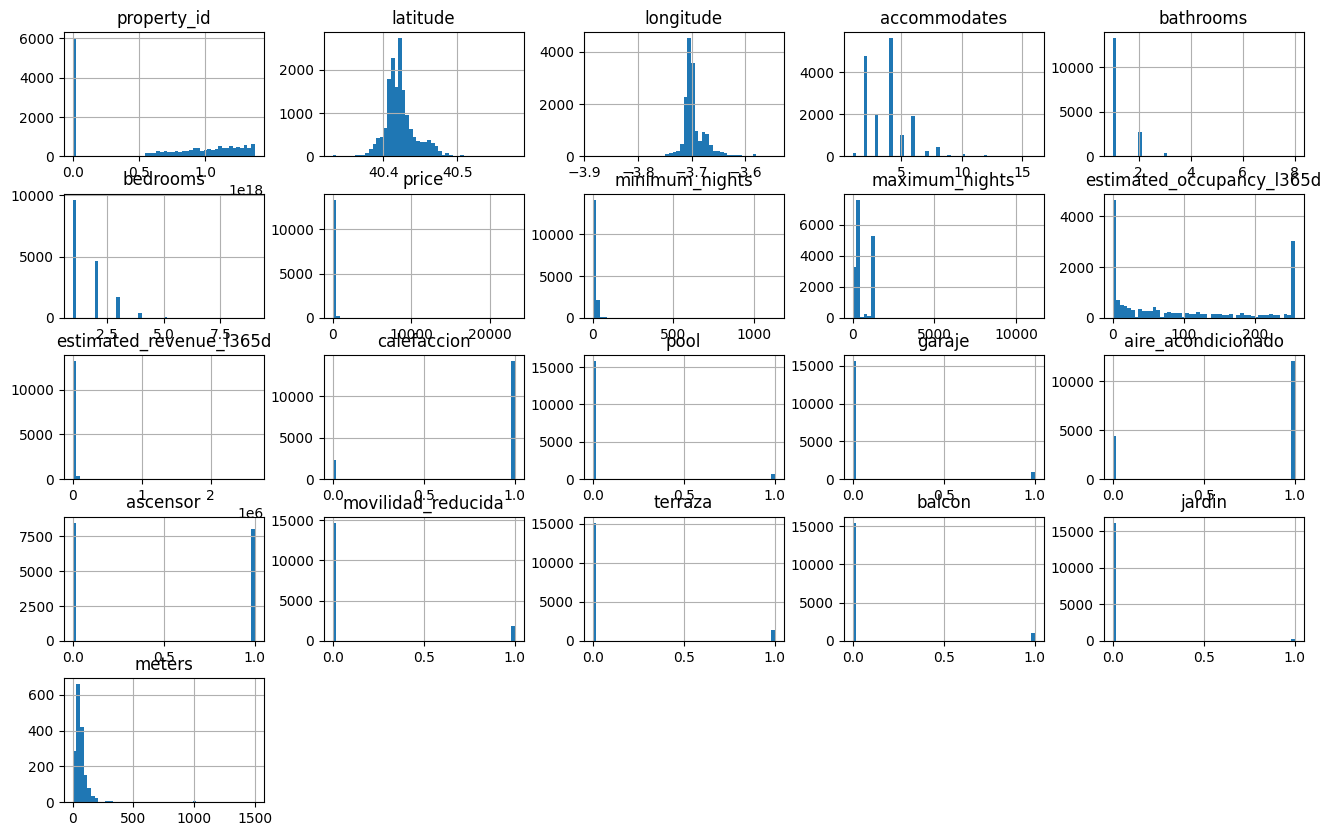

In [1132]:
import matplotlib.pyplot as plt
df.hist(bins=50,figsize=(16, 10))
plt.show()

In [1133]:
num_columns = df.select_dtypes(exclude='object').columns
num_columns

Index(['property_id', 'latitude', 'longitude', 'accommodates', 'bathrooms',
       'bedrooms', 'price', 'minimum_nights', 'maximum_nights',
       'estimated_occupancy_l365d', 'estimated_revenue_l365d', 'calefaccion',
       'pool', 'garaje', 'aire_acondicionado', 'ascensor',
       'movilidad_reducida', 'terraza', 'balcon', 'jardin', 'meters'],
      dtype='object')

In [1134]:
columns_to_drop = ['property_id','listing_url','name', 'description', 'name_description','neighbourhood_cleansed','amenities','minimum_nights','maximum_nights','room_type','property_type']
df.drop(columns=columns_to_drop, inplace=True)
df.columns

Index(['neighbourhood_group_cleansed', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'price', 'estimated_occupancy_l365d',
       'estimated_revenue_l365d', 'calefaccion', 'pool', 'garaje',
       'aire_acondicionado', 'ascensor', 'movilidad_reducida', 'terraza',
       'balcon', 'jardin', 'meters'],
      dtype='object')

In [1135]:
df.isnull().sum()

neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
price                            2901
estimated_occupancy_l365d           0
estimated_revenue_l365d          2901
calefaccion                         0
pool                                0
garaje                              0
aire_acondicionado                  0
ascensor                            0
movilidad_reducida                  0
terraza                             0
balcon                              0
jardin                              0
meters                          14844
dtype: int64

In [1136]:
len(df)

16527

In [1137]:
df.dropna(subset=['price','estimated_revenue_l365d',], how='any', inplace=True)

In [1138]:
df.isnull().sum()

neighbourhood_group_cleansed        0
latitude                            0
longitude                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
price                               0
estimated_occupancy_l365d           0
estimated_revenue_l365d             0
calefaccion                         0
pool                                0
garaje                              0
aire_acondicionado                  0
ascensor                            0
movilidad_reducida                  0
terraza                             0
balcon                              0
jardin                              0
meters                          12208
dtype: int64

In [1139]:
len(df)

13626

### Movilidad Reducida

No tiene sentido, movilidad_reducida a 1 y no tener ascensor. Solo tendria sentido si el piso o casa esta en la planta baja o acceso directo desde la calle.
Eliminamos todos los registros en los que ocurra esto

In [1140]:
df = df[(df["movilidad_reducida"] == 1) & (df["ascensor"] == 1) | (df["movilidad_reducida"] == 0)]

In [1141]:
len(df)

12951

### neighbourhood_group_cleansed

In [1142]:
df['neighbourhood_group_cleansed'].unique()

array(['Centro', 'Arganzuela', 'Chamberí', 'Fuencarral - El Pardo',
       'Hortaleza', 'Moncloa - Aravaca', 'Retiro',
       'San Blas - Canillejas', 'Barajas', 'Moratalaz', 'Ciudad Lineal',
       'Salamanca', 'Chamartín', 'Tetuán', 'Villaverde', 'Carabanchel',
       'Latina', 'Vicálvaro', 'Puente de Vallecas', 'Usera',
       'Villa de Vallecas'], dtype=object)

In [1143]:
df[['neighbourhood_group_cleansed','price']].groupby('neighbourhood_group_cleansed').count()

,price
neighbourhood_group_cleansed,
Arganzuela,642
Barajas,43
Carabanchel,325
Centro,6230
Chamartín,460
Chamberí,862
Ciudad Lineal,302
Fuencarral - El Pardo,112
Hortaleza,217


In [1144]:
#Calculate column 
df["price_pers"] = df['price'] / df["accommodates"]

<Axes: >

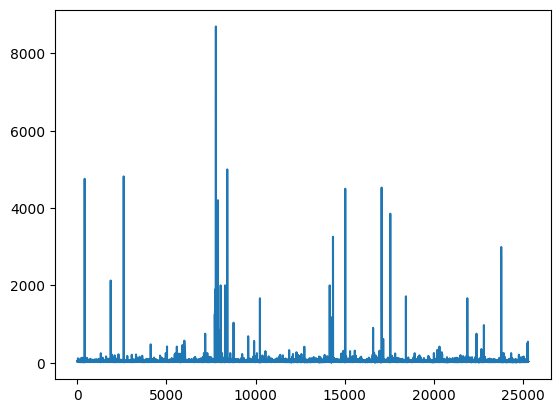

In [1145]:
df["price_pers"].plot()

In [1146]:
df.dtypes

neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
accommodates                      int64
bathrooms                         int64
bedrooms                          int64
price                           float64
estimated_occupancy_l365d         int64
estimated_revenue_l365d         float64
calefaccion                       int64
pool                              int64
garaje                            int64
aire_acondicionado                int64
ascensor                          int64
movilidad_reducida                int64
terraza                           int64
balcon                            int64
jardin                            int64
meters                          float64
price_pers                      float64
dtype: object

In [1147]:
df['neighbourhood_group_cleansed'].value_counts()

neighbourhood_group_cleansed
Centro                   6230
Salamanca                1048
Tetuán                    919
Chamberí                  862
Arganzuela                642
Retiro                    506
Chamartín                 460
Carabanchel               325
Ciudad Lineal             302
Puente de Vallecas        283
Moncloa - Aravaca         270
Hortaleza                 217
Usera                     202
San Blas - Canillejas     194
Latina                    194
Fuencarral - El Pardo     112
Villaverde                 67
Barajas                    43
Villa de Vallecas          34
Moratalaz                  25
Vicálvaro                  16
Name: count, dtype: int64

<Axes: xlabel='neighbourhood_group_cleansed'>

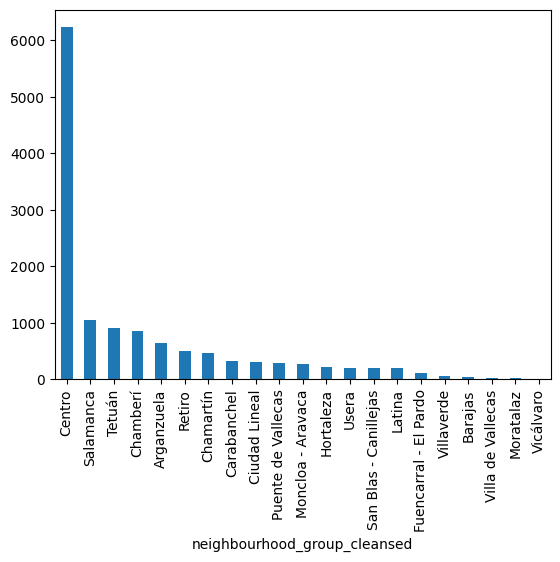

In [1148]:
df['neighbourhood_group_cleansed'].value_counts().plot.bar()

<Axes: xlabel='bedrooms'>

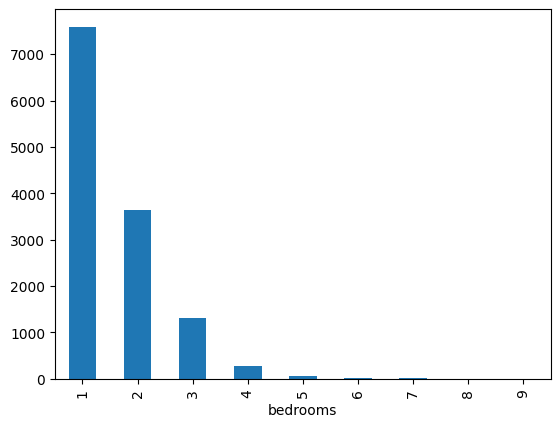

In [1149]:
df["bedrooms"].value_counts().plot.bar()

<Axes: xlabel='bathrooms'>

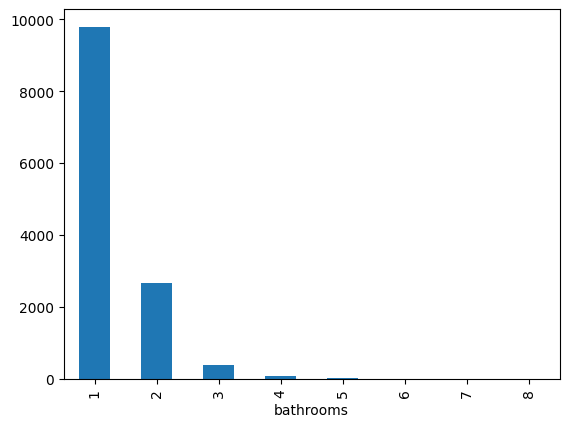

In [1150]:
df["bathrooms"].value_counts().plot.bar()

#### New Colunm distance_to_center

In [1151]:
center_lat, center_lon = 40.4168, -3.7038

# Create distance to city center
df['distance_to_center'] = np.sqrt((df['latitude'] - center_lat)**2 + (df['longitude'] - center_lon)**2)

#### New Column bath_bed_ratio

In [1152]:
df["bath_bed_ratio"] = df["bathrooms"] / df["bedrooms"]

#### New Column renta_bin

In [1153]:
df["renta_bin"] = df['neighbourhood_group_cleansed'].apply(lambda x: get_renta_bin(x))

#### New Column es_Centro

In [1154]:
def get_es_Centro(neighbourhood):
    if neighbourhood == 'Centro':
        return 1
    return 0

In [1155]:
df["es_centro"] = df['neighbourhood_group_cleansed'].apply(lambda x: get_es_Centro(x))

In [1156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12951 entries, 5 to 25285
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  12951 non-null  object 
 1   latitude                      12951 non-null  float64
 2   longitude                     12951 non-null  float64
 3   accommodates                  12951 non-null  int64  
 4   bathrooms                     12951 non-null  int64  
 5   bedrooms                      12951 non-null  int64  
 6   price                         12951 non-null  float64
 7   estimated_occupancy_l365d     12951 non-null  int64  
 8   estimated_revenue_l365d       12951 non-null  float64
 9   calefaccion                   12951 non-null  int64  
 10  pool                          12951 non-null  int64  
 11  garaje                        12951 non-null  int64  
 12  aire_acondicionado            12951 non-null  int64  
 13  ascens

#### New Column nearest_metro_distance

##### Dataframe metro_madrid paradas

In [1157]:
df_metro = pd.read_csv('../metro_madrid/stops.txt', delimiter=',')
df_metro.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,par_4_1,1,PLAZA DE CASTILLA,Paseo de la Castellana 189,40.46690,-3.68917,A,http://www.crtm.es,0,est_90_21,NaN,0
1,acc_4_1_1,1,Plaza de Castilla,Paseo de la Castellana 189,40.46682,-3.68918,NaN,http://www.crtm.es,2,est_90_21,NaN,0
2,acc_4_1_1040,1,Ascensor,Plaza de Castilla 9,40.46555,-3.68877,NaN,http://www.crtm.es,2,est_90_21,NaN,0
3,acc_4_1_1043,1,Intercambiador Superficie,Paseo de la Castellana 191 B,40.46728,-3.68915,NaN,http://www.crtm.es,2,est_90_21,NaN,0
4,acc_4_1_1044,1,Ascensor,Paseo de la Castellana 189,40.46702,-3.68918,NaN,http://www.crtm.es,2,est_90_21,NaN,0


##### Calculo de distancia Ubicacion Alojamiento - Estacion de Metro

In [1158]:
df['nearest_metro_distance'] = df.apply(lambda row: get_nearest_metro_distance(row, df_metro), axis=1)

#### Outliers

In [1159]:
df_numerics_Q1 = df[['price_pers']].apply(lambda x: np.quantile(x,q=.25)) # indicadores de Q1
df_numerics_Q3 = df[['price_pers']].apply(lambda x: np.quantile(x,q=.75)) # indicadores de Q2
df_numerics_IQR = df_numerics_Q3 - df_numerics_Q1 # longitud del IQR
df_numerics_lower = df_numerics_Q1 - 1.5 * df_numerics_IQR # limite inferior
df_numerics_upper = df_numerics_Q3 + 1.5 * df_numerics_IQR # limite superior
print(f"Outliers: Low:{df_numerics_lower} High:{df_numerics_upper}")

Outliers: Low:price_pers   -6.701923
dtype: float64 High:price_pers    79.221154
dtype: float64


In [1160]:
df.shape

(12951, 25)

In [1161]:
df_numerics_over_max = df[['price_pers']].apply(lambda x: x> df_numerics_upper,axis=1) # comprobamos que valores están por encima del máximo
df_numerics_below_min = df[['price_pers']].apply(lambda x: x< df_numerics_lower,axis=1) # comprobamos que valores están por encima del máximo
pd.DataFrame({"outlier_below":df_numerics_below_min.sum(),
              "outlier_above":df_numerics_over_max.sum()})

,outlier_below,outlier_above
price_pers,0,604


In [1162]:
samples_with_outliers_price_pers = df_numerics_below_min.any(axis=1) | df_numerics_over_max.any(axis=1)

In [1163]:
df_with_outliers = df[samples_with_outliers_price_pers]

<Axes: title={'center': 'Muestras con outliers'}, xlabel='bedrooms', ylabel='price_pers'>

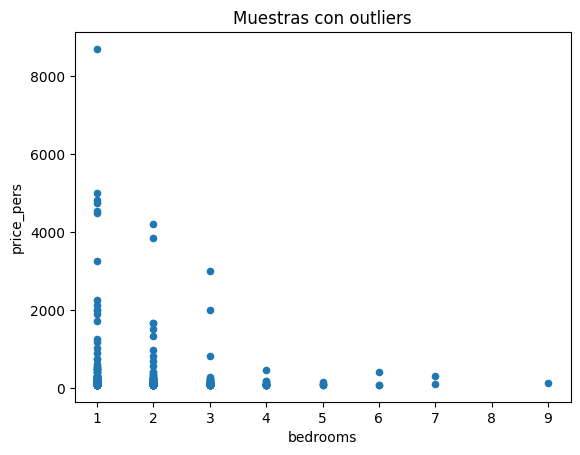

In [1164]:
# Exploración de las muestras con outliers,
df_with_outliers.plot.scatter(x="bedrooms",y="price_pers", title="Muestras con outliers")

<Axes: title={'center': 'Muestras sin outliers Clásicos'}, xlabel='bedrooms', ylabel='price_pers'>

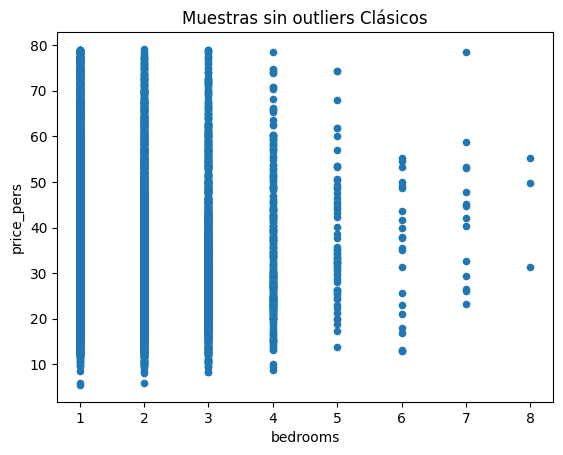

In [1165]:
# Exploración de las muestras sin outliers,
df[~samples_with_outliers_price_pers].plot.scatter(x="bedrooms",y="price_pers", title="Muestras sin outliers Clásicos")

In [1166]:
df = df[~samples_with_outliers_price_pers]

In [1167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12347 entries, 5 to 25285
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   neighbourhood_group_cleansed  12347 non-null  object 
 1   latitude                      12347 non-null  float64
 2   longitude                     12347 non-null  float64
 3   accommodates                  12347 non-null  int64  
 4   bathrooms                     12347 non-null  int64  
 5   bedrooms                      12347 non-null  int64  
 6   price                         12347 non-null  float64
 7   estimated_occupancy_l365d     12347 non-null  int64  
 8   estimated_revenue_l365d       12347 non-null  float64
 9   calefaccion                   12347 non-null  int64  
 10  pool                          12347 non-null  int64  
 11  garaje                        12347 non-null  int64  
 12  aire_acondicionado            12347 non-null  int64  
 13  ascens

## Models

Model not considerating meters, we are going to create a model to predict the price per night

### Model 001

In [1168]:
dfm = df.copy()
dfm = dfm[['neighbourhood_group_cleansed','bathrooms','bedrooms','price','calefaccion','pool','garaje','aire_acondicionado','ascensor','movilidad_reducida','terraza','balcon','jardin']]
dfm

,neighbourhood_group_cleansed,bathrooms,bedrooms,price,calefaccion,pool,garaje,aire_acondicionado,ascensor,movilidad_reducida,terraza,balcon,jardin
5,Centro,1,1,66.0,1,0,0,0,1,0,0,1,0
6,Centro,1,1,89.0,1,0,0,1,0,0,0,0,0
7,Centro,1,3,173.0,1,0,0,1,0,0,1,0,0
9,Centro,1,1,72.0,1,0,0,1,1,1,0,0,0
10,Centro,1,3,189.0,1,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25281,Tetuán,1,1,67.0,0,0,0,1,0,0,0,0,0
25282,Tetuán,1,1,63.0,0,0,0,1,0,0,0,0,0
25283,Hortaleza,1,1,103.0,1,0,0,1,1,1,1,0,0
25284,Carabanchel,1,2,100.0,0,0,0,1,0,0,0,0,0


In [1169]:
dfm.dtypes

neighbourhood_group_cleansed     object
bathrooms                         int64
bedrooms                          int64
price                           float64
calefaccion                       int64
pool                              int64
garaje                            int64
aire_acondicionado                int64
ascensor                          int64
movilidad_reducida                int64
terraza                           int64
balcon                            int64
jardin                            int64
dtype: object

In [1170]:
dfm.shape

(12347, 13)

In [1171]:
df_nums = dfm.select_dtypes(include='number')
df_cat = dfm.select_dtypes(exclude='number')


In [1172]:
df_nums.describe()

,bathrooms,bedrooms,price,calefaccion,pool,garaje,aire_acondicionado,ascensor,movilidad_reducida,terraza,balcon,jardin
count,12347.000000,12347.000000,12347.00000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000,12347.000000
mean,1.289301,1.590184,132.25488,0.862396,0.043816,0.049648,0.740180,0.503442,0.071839,0.077185,0.062768,0.018142
std,0.577300,0.844663,75.86024,0.344498,0.204694,0.217225,0.438554,0.500008,0.258232,0.266895,0.242556,0.133470
min,1.000000,1.000000,11.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,86.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,112.00000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,153.00000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,7.000000,8.000000,1021.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<Axes: xlabel='neighbourhood_group_cleansed'>

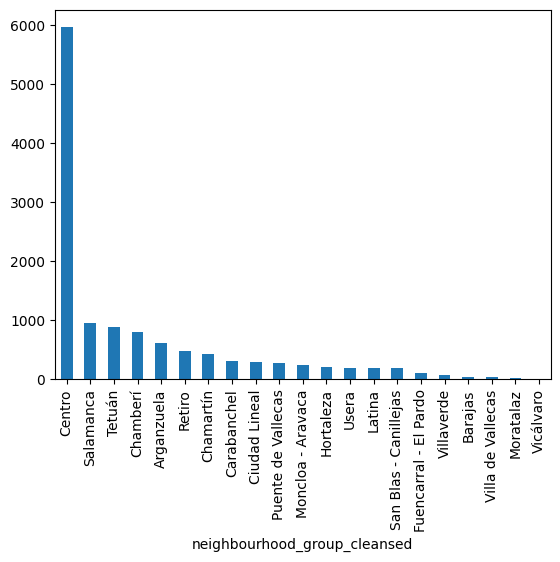

In [1173]:
dfm['neighbourhood_group_cleansed'].value_counts().plot.bar()

#### Outliers

In [1174]:
df_nums.shape

(12347, 12)

<Axes: >

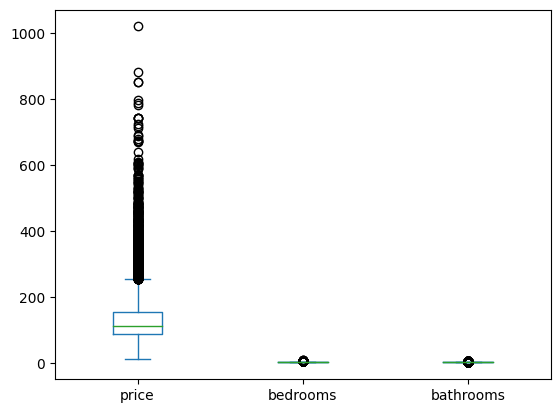

In [1175]:
df_nums[['price','bedrooms','bathrooms']].plot.box()

In [1176]:
#Cuantiles en el a partir del precio

In [1177]:
df_numerics_Q1 = df_nums[['price']].apply(lambda x: np.quantile(x,q=.25)) # indicadores de Q1
df_numerics_Q3 = df_nums[['price']].apply(lambda x: np.quantile(x,q=.75)) # indicadores de Q2
df_numerics_IQR = df_numerics_Q3 - df_numerics_Q1 # longitud del IQR
df_numerics_lower = df_numerics_Q1 - 1.5 * df_numerics_IQR # limite inferior
df_numerics_upper = df_numerics_Q3 + 1.5 * df_numerics_IQR # limite superior

In [1178]:
df_numerics_over_max = df_nums[['price']].apply(lambda x: x> df_numerics_upper, # comprobamos que valores están por encima del máximo
                       axis=1)
df_numerics_below_min = df_nums[['price']].apply(lambda x: x< df_numerics_lower, # comprobamos que valores están por encima del máximo
                       axis=1)

In [1179]:
pd.DataFrame({"outlier_below":df_numerics_below_min.sum(),
              "outlier_above":df_numerics_over_max.sum()})

,outlier_below,outlier_above
price,0,750


In [1180]:
# seleccionamos las muestras que tienen outliers, por debajo o por encima
samples_with_outliers_price = df_numerics_below_min.any(axis=1) | df_numerics_over_max.any(axis=1)

In [1181]:
df_with_outliers = df_nums[samples_with_outliers_price]

<Axes: title={'center': 'Muestras con outliers'}, xlabel='bedrooms', ylabel='price'>

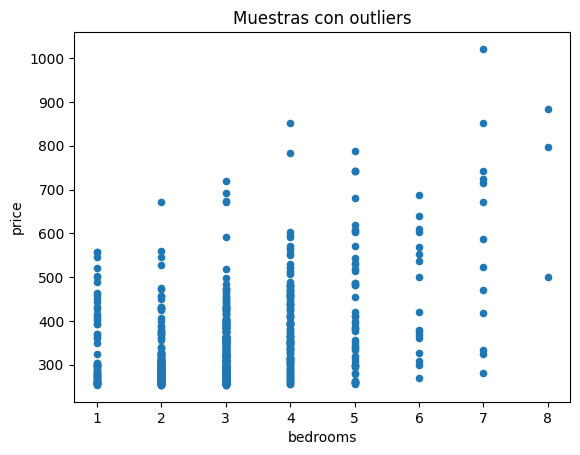

In [1182]:
# Exploración de las muestras con outliers,
df_with_outliers.plot.scatter(x="bedrooms",y="price", title="Muestras con outliers")

<Axes: title={'center': 'Muestras sin outliers Clásicos'}, xlabel='bedrooms', ylabel='price'>

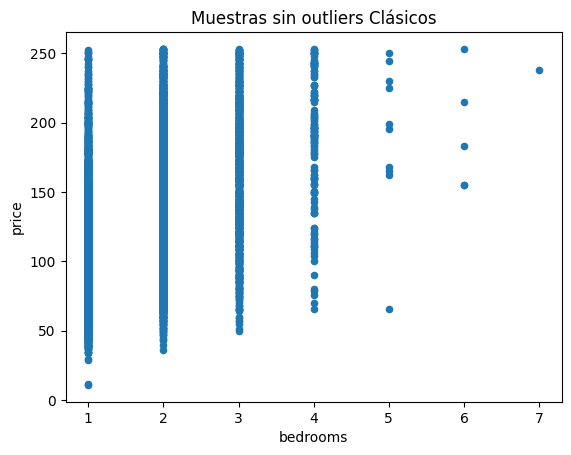

In [1183]:
# Exploración de las muestras sin outliers,
df_nums[~samples_with_outliers_price].plot.scatter(x="bedrooms",y="price", title="Muestras sin outliers Clásicos")

In [1184]:
#Cogemos los datos sin outliers
df_nums = df_nums[~samples_with_outliers_price]

In [1185]:
df_nums.shape

(11597, 12)

We are going only to consider:
'bathrooms','bedrooms','price','calefaccion','pool','garaje','aire_acondicionado','ascensor','movilidad_reducida','terraza','jardin','balcon'

Paso 1- Quitamos garaje, jardin y pool por que nos da que tiene un efecto negativo en la prediccion

In [1186]:
dfm = dfm[['bathrooms','bedrooms','price','calefaccion','aire_acondicionado','ascensor','movilidad_reducida','terraza','balcon']]

In [1187]:
dfm.dtypes

bathrooms               int64
bedrooms                int64
price                 float64
calefaccion             int64
aire_acondicionado      int64
ascensor                int64
movilidad_reducida      int64
terraza                 int64
balcon                  int64
dtype: object

In [1188]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [1189]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

In [1190]:
model = linear_model.LinearRegression()
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})

In [1191]:
test_predict_analysis = test_predict_analysis.sort_values("y")
train_predict_analysis = train_predict_analysis.sort_values("y")

In [1192]:
train_predict_analysis.head(20)

,y,y_pred
17004,11.0,96.819218
22507,12.0,96.819218
23067,29.0,89.660297
6676,30.0,116.756093
16851,34.0,96.819218
562,35.0,105.642037
10228,35.0,88.412732
24254,36.0,137.493127
17607,37.0,89.660297
6493,37.0,96.819218


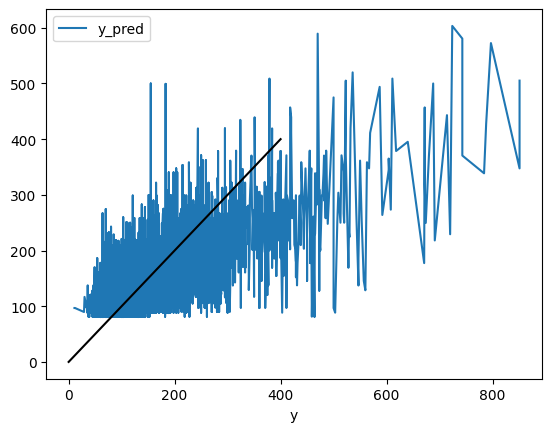

In [1193]:
train_predict_analysis.plot.line(x="y",y="y_pred")
plt.plot((0,400),(0,400),c="k")

En el grafico se esta viendo que por ejemplo para una casa de 50 estamos dando una prediccion de 100 a 150

In [1194]:
train_predict_analysis["y_pred_diff"]=train_predict_analysis["y_pred"]-train_predict_analysis["y"]

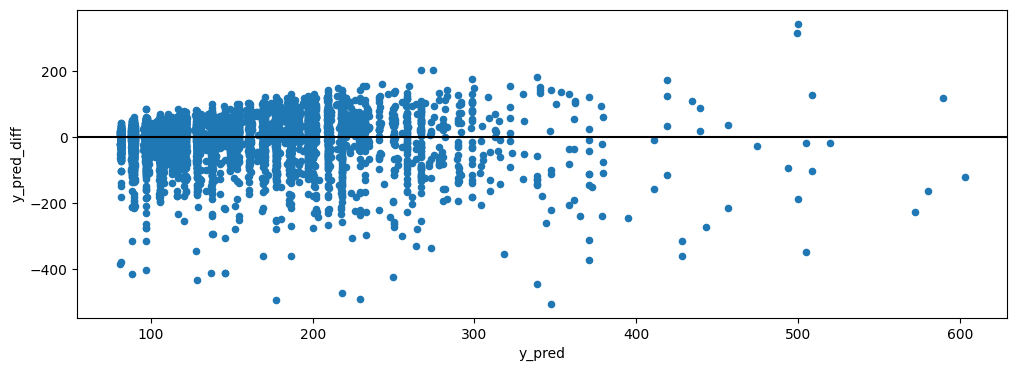

In [1195]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")

<Axes: ylabel='Frequency'>

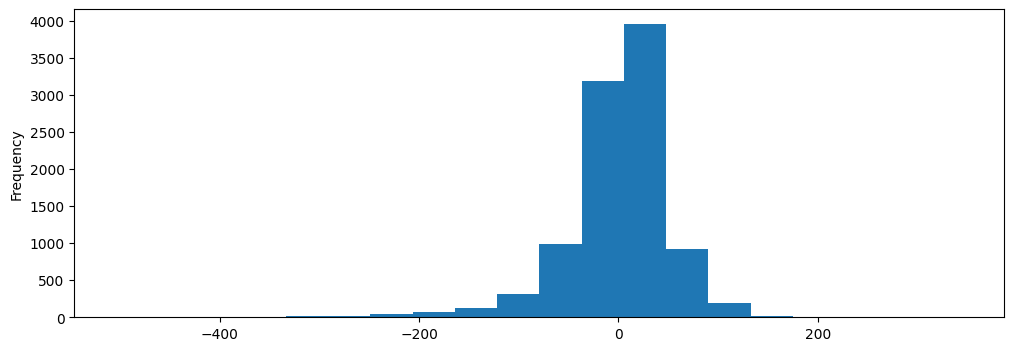

In [1196]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis["y_pred_diff"].plot.hist(bins=20)

In [1197]:
importance = pd.Series(model.coef_, index=X_train.columns)
print(importance.sort_values(ascending=False))

bathrooms             48.771362
bedrooms              31.851090
balcon                13.919011
movilidad_reducida    11.114056
ascensor               8.822819
aire_acondicionado     8.406486
calefaccion            7.158921
terraza               -0.677622
dtype: float64


In [1198]:
get_results(X_train, y_train, X_test, y_test)

100%|██████████| 7/7 [00:00<00:00,  9.43it/s]


,r2,mse,rmse,mape
lr,0.507836,2846.349424,53.351190,0.295126
ridge,0.507836,2846.349424,53.351190,0.295126
lasso,0.502486,2877.291611,53.640392,0.298413
SGD,0.499572,2894.144960,53.797258,0.315521
HuberRegressor,0.492532,2934.858506,54.174334,0.273762
Elastic,0.426203,3318.460942,57.606084,0.325486
XGBRegressor,0.460131,3122.243927,55.877043,0.297310


### Model 001_01

In [1199]:
dfm = df.copy()

In [1200]:
dfm.shape

(12347, 25)

Añadimos la columna renta_bin

In [1201]:
dfm = dfm[['bathrooms','bedrooms','price','calefaccion','aire_acondicionado','ascensor','movilidad_reducida','terraza','balcon','renta_bin','pool','garaje','jardin']]

In [1202]:
dfm.dtypes

bathrooms               int64
bedrooms                int64
price                 float64
calefaccion             int64
aire_acondicionado      int64
ascensor                int64
movilidad_reducida      int64
terraza                 int64
balcon                  int64
renta_bin              object
pool                    int64
garaje                  int64
jardin                  int64
dtype: object

In [1203]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [1204]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

In [1205]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

In [1206]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [1207]:
model = linear_model.LinearRegression()
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})

In [1208]:
test_predict_analysis = test_predict_analysis.sort_values("y")
train_predict_analysis = train_predict_analysis.sort_values("y")

In [1209]:
train_predict_analysis.head(20)

,y,y_pred
17004,11.0,75.263460
22507,12.0,75.263460
23067,29.0,95.572712
6676,30.0,110.904886
16851,34.0,101.859372
562,35.0,106.295608
10228,35.0,93.476276
24254,36.0,142.465686
17607,37.0,88.291033
6493,37.0,101.859372


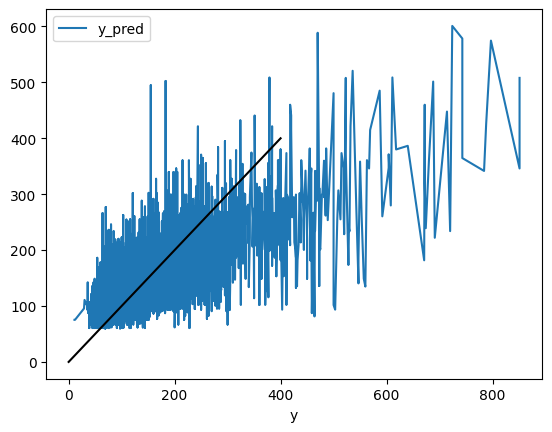

In [1210]:
train_predict_analysis.plot.line(x="y",y="y_pred")
plt.plot((0,400),(0,400),c="k")

En el grafico se esta viendo que por ejemplo para una casa de 50 estamos dando una prediccion de 100 a 150

In [1211]:
train_predict_analysis["y_pred_diff"]=train_predict_analysis["y_pred"]-train_predict_analysis["y"]

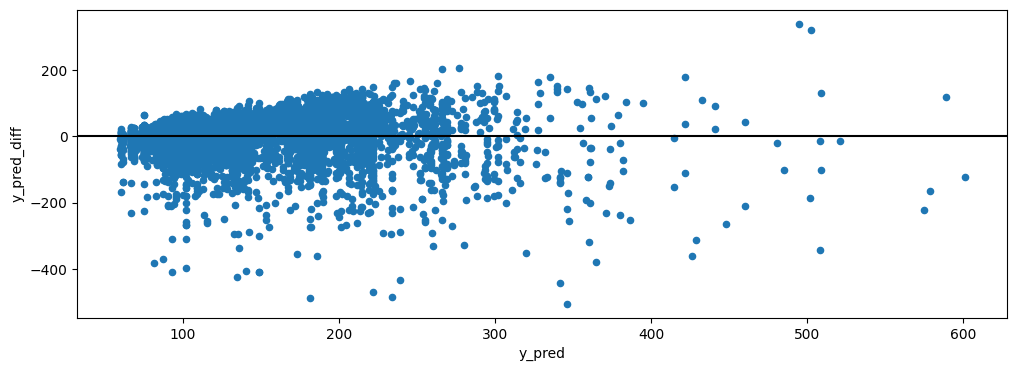

In [1212]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")

<Axes: ylabel='Frequency'>

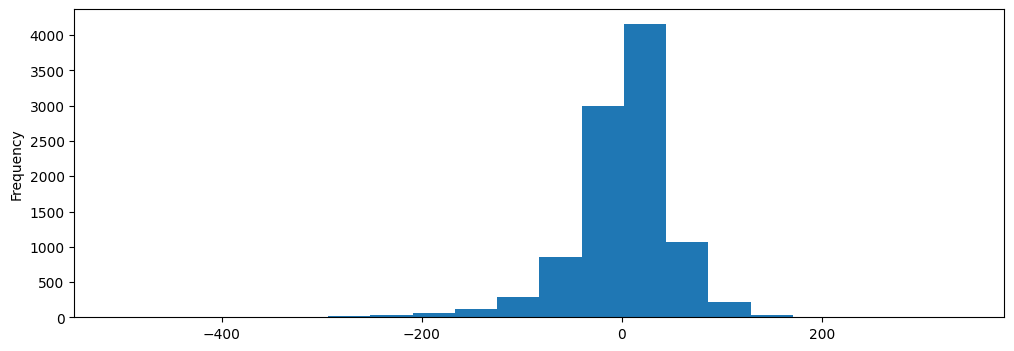

In [1213]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis["y_pred_diff"].plot.hist(bins=20)

In [1214]:
num_features = numerical_features.tolist()

# Extract names from one-hot encoded categorical features
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_feature)

# Combine all names
feature_names = num_features + list(cat_feature_names)

# 6. Create a DataFrame with coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=np.abs, ascending=False)

# 7. Show top features
print(coef_df)

               Feature  Coefficient
1             bedrooms    27.627014
0            bathrooms    27.052474
14  renta_bin_muy_bajo   -23.663481
12     renta_bin_medio   -15.604575
13  renta_bin_muy_alto    -3.915634
4             ascensor     3.684233
3   aire_acondicionado     3.664472
5   movilidad_reducida     3.077366
7               balcon     2.965530
11      renta_bin_bajo     2.932430
2          calefaccion     2.172918
9               garaje    -1.591791
6              terraza     0.273620
10              jardin    -0.109623
8                 pool     0.062521


In [1215]:
get_results(X_train, y_train, X_test, y_test)

100%|██████████| 7/7 [00:00<00:00,  8.15it/s]


,r2,mse,rmse,mape
lr,0.519336,2779.839720,52.724185,0.287090
ridge,0.519336,2779.839720,52.724185,0.287090
lasso,0.514768,2806.261181,52.974156,0.291049
SGD,0.517375,2791.180895,52.831628,0.288446
HuberRegressor,0.503769,2869.871294,53.571180,0.265315
Elastic,0.482496,2992.896240,54.707369,0.305169
XGBRegressor,0.494961,2920.810383,54.044522,0.288605


Mejoramos un poco el modelo

### Model 001_02

Considerando neighbourhood_group_cleansed -> Distrito

In [1216]:
dfm = df.copy()

In [1217]:
dfm.dtypes

neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
accommodates                      int64
bathrooms                         int64
bedrooms                          int64
price                           float64
estimated_occupancy_l365d         int64
estimated_revenue_l365d         float64
calefaccion                       int64
pool                              int64
garaje                            int64
aire_acondicionado                int64
ascensor                          int64
movilidad_reducida                int64
terraza                           int64
balcon                            int64
jardin                            int64
meters                          float64
price_pers                      float64
distance_to_center              float64
bath_bed_ratio                  float64
renta_bin                        object
es_centro                         int64
nearest_metro_distance          float64


In [1218]:
dfm.shape

(12347, 25)

In [1219]:
dfm = dfm[['neighbourhood_group_cleansed','bathrooms','bedrooms','price','calefaccion','aire_acondicionado','ascensor','movilidad_reducida','terraza','balcon','pool','garaje','jardin']]

In [1220]:
dfm.dtypes

neighbourhood_group_cleansed     object
bathrooms                         int64
bedrooms                          int64
price                           float64
calefaccion                       int64
aire_acondicionado                int64
ascensor                          int64
movilidad_reducida                int64
terraza                           int64
balcon                            int64
pool                              int64
garaje                            int64
jardin                            int64
dtype: object

In [1221]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [1222]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

In [1223]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

In [1224]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [1225]:
model = linear_model.LinearRegression()
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})

In [1226]:
test_predict_analysis = test_predict_analysis.sort_values("y")
train_predict_analysis = train_predict_analysis.sort_values("y")

In [1227]:
train_predict_analysis.head(20)

,y,y_pred
17004,11.0,69.169408
22507,12.0,69.169408
23067,29.0,66.652349
6676,30.0,116.005609
16851,34.0,108.261277
562,35.0,102.401366
10228,35.0,100.513282
24254,36.0,121.196045
17607,37.0,63.027225
6493,37.0,108.261277


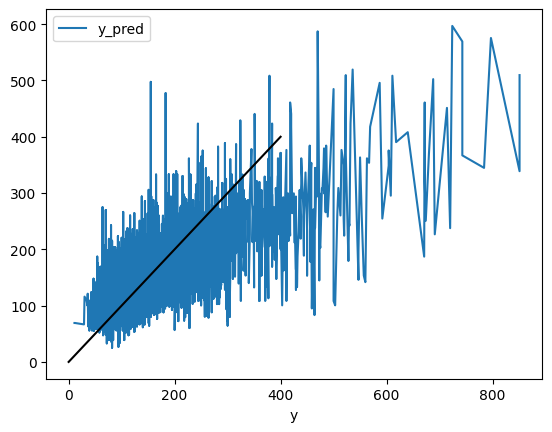

In [1228]:
train_predict_analysis.plot.line(x="y",y="y_pred")
plt.plot((0,400),(0,400),c="k")

In [1229]:
train_predict_analysis["y_pred_diff"]=train_predict_analysis["y_pred"]-train_predict_analysis["y"]

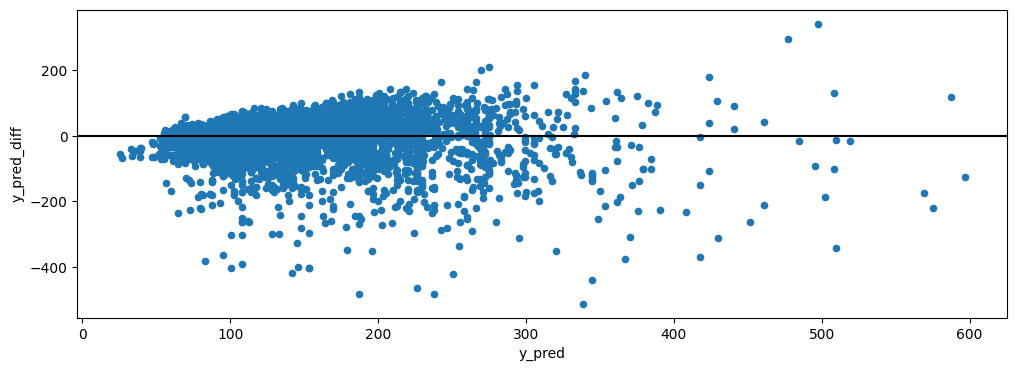

In [1230]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")

<Axes: ylabel='Frequency'>

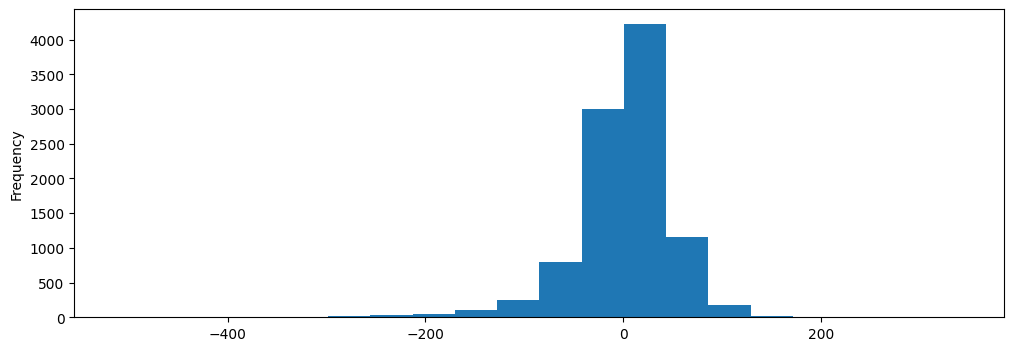

In [1231]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis["y_pred_diff"].plot.hist(bins=20)

In [1232]:
num_features = numerical_features.tolist()

# Extract names from one-hot encoded categorical features
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_feature)

# Combine all names
feature_names = num_features + list(cat_feature_names)

# 6. Create a DataFrame with coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=np.abs, ascending=False)

# 7. Show top features
print(coef_df)

                                              Feature  Coefficient
28             neighbourhood_group_cleansed_Vicálvaro   -61.899350
21             neighbourhood_group_cleansed_Moratalaz   -42.982683
24             neighbourhood_group_cleansed_Salamanca    29.313130
1                                            bedrooms    28.102009
29     neighbourhood_group_cleansed_Villa de Vallecas   -26.691980
13                neighbourhood_group_cleansed_Centro    26.458506
0                                           bathrooms    26.095736
25  neighbourhood_group_cleansed_San Blas - Canill...   -20.229380
17  neighbourhood_group_cleansed_Fuencarral - El P...   -16.225274
15              neighbourhood_group_cleansed_Chamberí    14.504925
30            neighbourhood_group_cleansed_Villaverde   -13.348908
27                 neighbourhood_group_cleansed_Usera   -12.633363
20     neighbourhood_group_cleansed_Moncloa - Aravaca    12.163874
14             neighbourhood_group_cleansed_Chamartín    11.36

In [1233]:
get_results(X_train, y_train, X_test, y_test)

 57%|█████▋    | 4/7 [00:00<00:00,  9.82it/s]/Users/jayarza/.local/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
100%|██████████| 7/7 [00:01<00:00,  4.73it/s]


,r2,mse,rmse,mape
lr,0.531272,2710.808657,52.065427,0.285697
ridge,0.531272,2710.808657,52.065427,0.285697
lasso,0.524715,2748.734637,52.428376,0.289269
SGD,0.531350,2710.360274,52.061121,0.284421
HuberRegressor,0.517090,2792.832531,52.847257,0.261421
Elastic,0.487006,2966.817122,54.468497,0.303765
XGBRegressor,0.526192,2740.187870,52.346804,0.277917


### Model 002

Considerando el target price/persona en vez del precio

In [1234]:
dfm = df.copy()

In [1235]:
dfm.dtypes

neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
accommodates                      int64
bathrooms                         int64
bedrooms                          int64
price                           float64
estimated_occupancy_l365d         int64
estimated_revenue_l365d         float64
calefaccion                       int64
pool                              int64
garaje                            int64
aire_acondicionado                int64
ascensor                          int64
movilidad_reducida                int64
terraza                           int64
balcon                            int64
jardin                            int64
meters                          float64
price_pers                      float64
distance_to_center              float64
bath_bed_ratio                  float64
renta_bin                        object
es_centro                         int64
nearest_metro_distance          float64


In [1236]:
dfm = dfm[['neighbourhood_group_cleansed','bathrooms','bedrooms','price_pers','calefaccion','pool','garaje','aire_acondicionado','ascensor','movilidad_reducida','terraza','balcon','jardin']]
dfm

,neighbourhood_group_cleansed,bathrooms,bedrooms,price_pers,calefaccion,pool,garaje,aire_acondicionado,ascensor,movilidad_reducida,terraza,balcon,jardin
5,Centro,1,1,33.000000,1,0,0,0,1,0,0,1,0
6,Centro,1,1,44.500000,1,0,0,1,0,0,0,0,0
7,Centro,1,3,28.833333,1,0,0,1,0,0,1,0,0
9,Centro,1,1,36.000000,1,0,0,1,1,1,0,0,0
10,Centro,1,3,31.500000,1,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25281,Tetuán,1,1,33.500000,0,0,0,1,0,0,0,0,0
25282,Tetuán,1,1,31.500000,0,0,0,1,0,0,0,0,0
25283,Hortaleza,1,1,34.333333,1,0,0,1,1,1,1,0,0
25284,Carabanchel,1,2,20.000000,0,0,0,1,0,0,0,0,0


In [1237]:
dfm.sort_values(by='price_pers',ascending=False).head(10)

,neighbourhood_group_cleansed,bathrooms,bedrooms,price_pers,calefaccion,pool,garaje,aire_acondicionado,ascensor,movilidad_reducida,terraza,balcon,jardin
4299,Centro,2,2,79.166667,1,0,0,1,1,0,0,1,0
19094,Centro,1,1,79.000000,1,0,0,1,1,0,0,0,0
8060,Centro,1,1,79.000000,1,0,0,1,0,0,0,0,0
12787,Hortaleza,2,3,79.000000,1,1,1,1,0,0,0,0,0
24929,Tetuán,1,1,79.000000,1,0,1,1,1,0,0,0,0
14997,Centro,1,1,79.000000,1,0,0,0,0,0,0,0,0
7634,Centro,1,1,79.000000,1,0,0,1,1,1,0,0,0
23817,Centro,1,1,79.000000,0,0,0,1,0,0,0,0,0
17312,Centro,1,1,79.000000,0,0,0,1,0,0,0,0,0
677,Centro,1,1,79.000000,1,0,0,1,1,0,1,0,0


In [1238]:
dfm.shape

(12347, 13)

In [1239]:
dfm.drop(columns=['neighbourhood_group_cleansed'],inplace=True)

In [1240]:
target = "price_pers"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [1241]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

In [1242]:
model = linear_model.LinearRegression()
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})


In [1243]:
train_predict_analysis = train_predict_analysis.sort_values("y")
test_predict_analysis = test_predict_analysis.sort_values("y")

We are going to look train error ( Residuos)

In [1244]:
train_predict_analysis.head(20)

,y,y_pred
17004,5.500000,35.839571
22507,6.000000,35.839571
24579,8.166667,36.394061
16700,8.250000,26.572715
16687,8.250000,26.572715
12016,8.500000,34.438178
16156,8.750000,31.625722
12850,9.500000,26.675135
310,9.500000,28.708499
13585,9.625000,35.674517


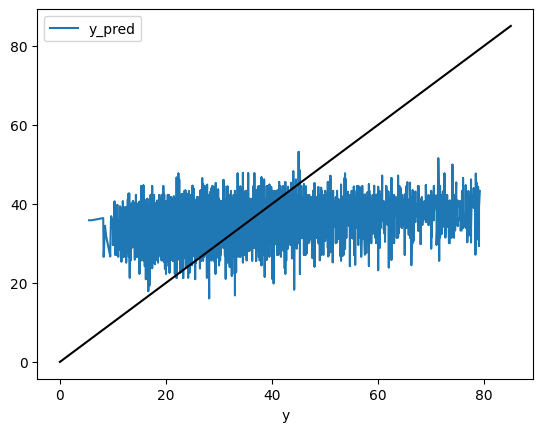

In [1245]:
train_predict_analysis.plot.line(x="y",y="y_pred")
plt.plot((0,85),(0,85),c="k")

In [1246]:
train_predict_analysis["y_pred_diff"]=train_predict_analysis["y_pred"]-train_predict_analysis["y"]

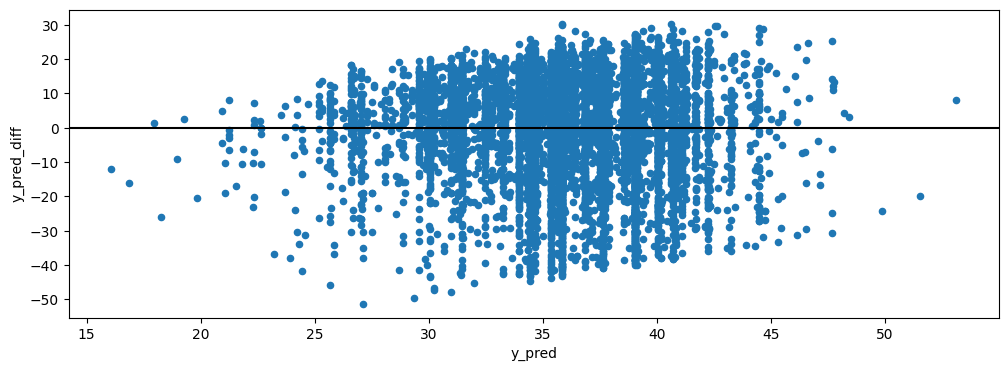

In [1247]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")

In [1248]:
importance = pd.Series(model.coef_, index=X_train.columns)
print(importance.sort_values(ascending=False))

bathrooms             5.425249
ascensor              3.201892
balcon                3.196447
terraza               1.661122
pool                  1.578965
aire_acondicionado    1.401393
calefaccion           0.474662
jardin                0.391664
movilidad_reducida    0.100404
bedrooms             -4.396097
garaje               -4.712403
dtype: float64


Vamos a probar con mas modelos

In [1249]:
get_results(X_train, y_train, X_test, y_test)

100%|██████████| 7/7 [00:00<00:00,  8.33it/s]


,r2,mse,rmse,mape
lr,0.066395,192.510095,13.874801,0.366305
ridge,0.066395,192.510095,13.874801,0.366305
lasso,0.001216,205.950153,14.350963,0.386913
SGD,0.066188,192.552840,13.876341,0.367752
HuberRegressor,0.058596,194.118373,13.932637,0.343385
Elastic,0.010384,204.059678,14.284946,0.384630
XGBRegressor,0.046602,196.591523,14.021110,0.365512


### Model 003

Considering Rentas of every neighbourhood to do a bucket and one hot encoder

In [1250]:
dfm = df.copy()

In [1251]:
dfm.dtypes

neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
accommodates                      int64
bathrooms                         int64
bedrooms                          int64
price                           float64
estimated_occupancy_l365d         int64
estimated_revenue_l365d         float64
calefaccion                       int64
pool                              int64
garaje                            int64
aire_acondicionado                int64
ascensor                          int64
movilidad_reducida                int64
terraza                           int64
balcon                            int64
jardin                            int64
meters                          float64
price_pers                      float64
distance_to_center              float64
bath_bed_ratio                  float64
renta_bin                        object
es_centro                         int64
nearest_metro_distance          float64


In [1252]:
dfm = dfm[['neighbourhood_group_cleansed','bathrooms','bedrooms','calefaccion','pool','garaje','aire_acondicionado','ascensor','movilidad_reducida','terraza','balcon','jardin','price_pers', 'renta_bin']]

In [1253]:
dfm.shape

(12347, 14)

In [1254]:
dfm.head()

,neighbourhood_group_cleansed,bathrooms,bedrooms,calefaccion,pool,garaje,aire_acondicionado,ascensor,movilidad_reducida,terraza,balcon,jardin,price_pers,renta_bin
5,Centro,1,1,1,0,0,0,1,0,0,1,0,33.000000,bajo
6,Centro,1,1,1,0,0,1,0,0,0,0,0,44.500000,bajo
7,Centro,1,3,1,0,0,1,0,0,1,0,0,28.833333,bajo
9,Centro,1,1,1,0,0,1,1,1,0,0,0,36.000000,bajo
10,Centro,1,3,1,0,0,1,1,0,1,0,0,31.500000,bajo


In [1255]:
df_rentas.sort_values(by='Renta neta media por persona', ascending=True)


,Distrito,Renta neta media por persona,Renta neta media por hogar,Media de la renta neta por unidad de consumo,Mediana de la renta neta por unidad de consumo,Renta bruta media por persona,Renta media bruta por hogar,renta_bin
11,Usera,11430.0,31996.0,17143.0,15050.0,13481.0,37737.0,muy_bajo
12,Puente de Vallecas,11452.0,30339.0,16852.0,15050.0,13354.0,35380.0,muy_bajo
16,Villaverde,11563.0,32527.0,17366.0,15750.0,13604.0,38269.0,muy_bajo
10,Carabanchel,12764.0,33786.0,18831.0,16450.0,15239.0,40339.0,muy_bajo
17,Villa de Vallecas,14274.0,36998.0,21433.0,19250.0,17346.0,44960.0,muy_bajo
9,Latina,14375.0,35669.0,20833.0,18550.0,17267.0,42843.0,muy_bajo
18,Vicálvaro,14832.0,39505.0,22364.0,20650.0,18214.0,48513.0,bajo
19,San Blas - Canillejas,15902.0,41474.0,23785.0,19950.0,19768.0,51558.0,bajo
13,Moratalaz,16437.0,40325.0,23900.0,21350.0,20091.0,49289.0,bajo
14,Ciudad Lineal,17808.0,43738.0,26175.0,21350.0,22440.0,55112.0,bajo


<Axes: >

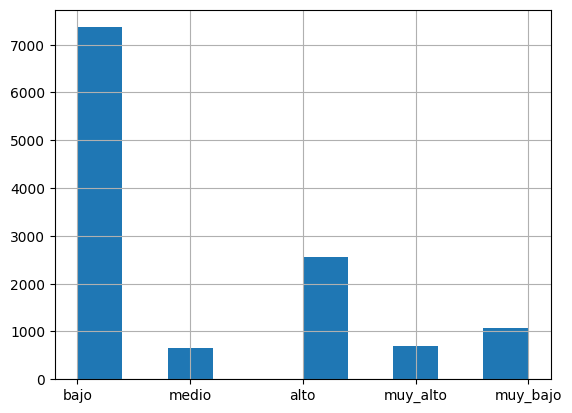

In [1256]:
dfm['renta_bin'].hist()

In [1257]:
dfm['renta_bin'].value_counts()

renta_bin
bajo        7367
alto        2555
muy_bajo    1077
muy_alto     686
medio        662
Name: count, dtype: int64

In [1258]:
dfm.shape

(12347, 14)

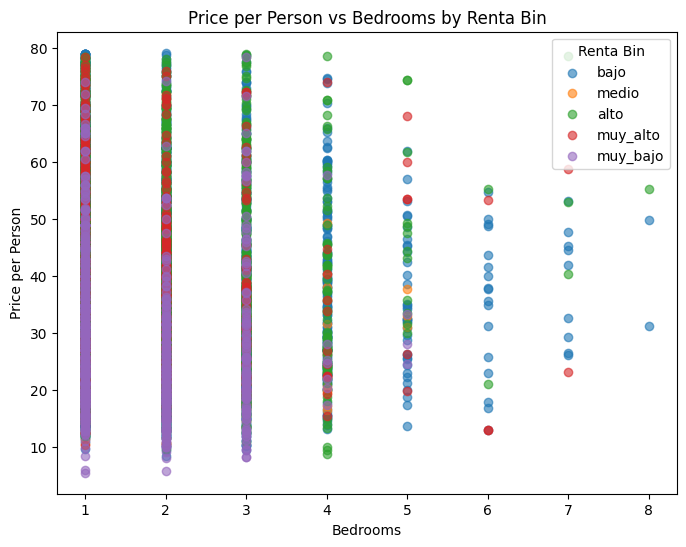

In [1259]:


plt.figure(figsize=(8, 6))
for renta in dfm['renta_bin'].unique():
    mask = dfm['renta_bin'] == renta
    plt.scatter(dfm.loc[mask, 'bedrooms'], dfm.loc[mask, 'price_pers'], label=renta, alpha=0.6)

plt.xlabel('Bedrooms')
plt.ylabel('Price per Person')
plt.title('Price per Person vs Bedrooms by Renta Bin')
plt.legend(title='Renta Bin')
plt.show()

In [1260]:
dfm.drop(columns=['neighbourhood_group_cleansed','bathrooms','jardin','pool','movilidad_reducida','garaje'],inplace=True)

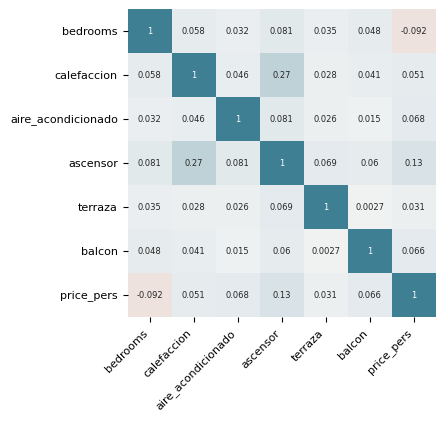

In [1261]:
import seaborn as sns

corr_matrix = dfm.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

In [1262]:
target = "price_pers"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [1263]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

X_train.select_dtypes(include='object').columns

In [1264]:
numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

In [1265]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('renta_bin', OneHotEncoder(drop='first'), categorical_feature )
    ])

In [1266]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [1267]:
preprocessor

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['bedrooms', 'calefaccion', 'aire_acondicionado', 'ascensor', 'terraza',
       'balcon'],
      dtype='object')),
                                ('renta_bin', OneHotEncoder(drop='first'),
                                 Index(['renta_bin'], dtype='object'))])

In [1268]:
model = linear_model.LinearRegression()
model.fit(X_train_preprocessed,y_train)
y_train_pred = model.predict(X_train_preprocessed)
y_test_pred = model.predict(X_test_preprocessed)

train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})

In [1269]:
train_predict_analysis.head(20)

,y,y_pred
23135,51.000000,34.943069
4965,24.000000,39.356911
24945,33.250000,36.534767
23176,22.250000,39.356911
617,53.000000,37.765213
20370,49.500000,39.085767
23015,47.666667,39.890148
11097,43.500000,36.534767
7413,30.000000,30.976125
4750,35.000000,35.750990


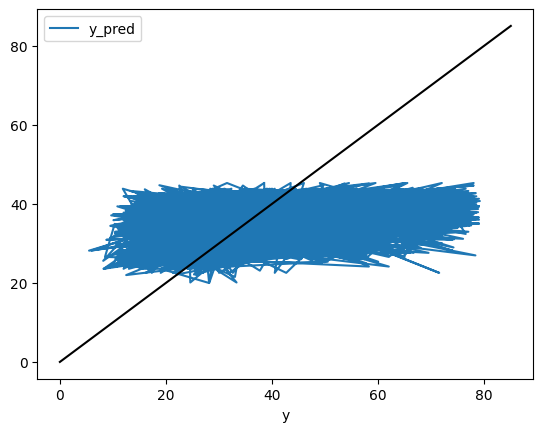

In [1270]:
train_predict_analysis.plot.line(x="y",y="y_pred")
plt.plot((0,85),(0,85),c="k")

In [1271]:
train_predict_analysis["y_pred_diff"]=train_predict_analysis["y_pred"]-train_predict_analysis["y"]

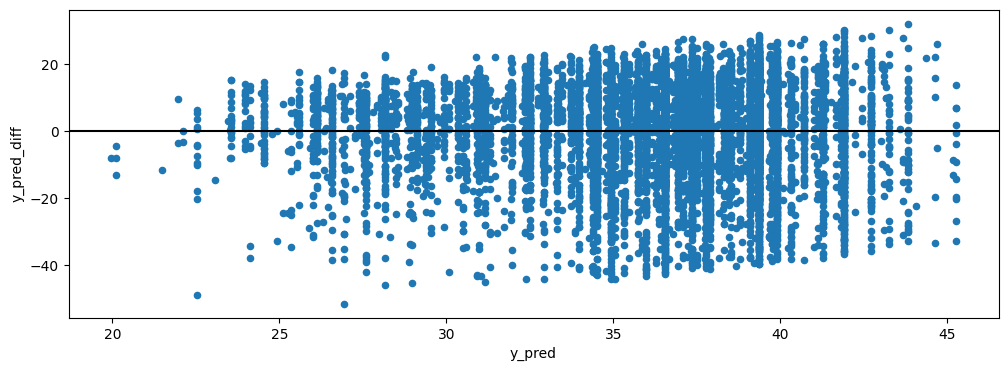

In [1272]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")

In [1273]:
get_results(X_train_preprocessed, y_train, X_test_preprocessed, y_test)

100%|██████████| 7/7 [00:00<00:00,  8.23it/s]


,r2,mse,rmse,mape
lr,0.067643,192.252880,13.865528,0.366721
ridge,0.067643,192.252880,13.865528,0.366721
lasso,0.015359,203.033743,14.248991,0.383529
SGD,0.067703,192.240549,13.865084,0.361924
HuberRegressor,0.058396,194.159558,13.934115,0.344650
Elastic,0.024594,201.129564,14.182016,0.381061
XGBRegressor,0.071059,191.548537,13.840106,0.361438


Peores resultados

In [1274]:
X_train_processed = pd.DataFrame(X_train_preprocessed, columns=preprocessor.get_feature_names_out())
X_train_processed.describe()

,num__bedrooms,num__calefaccion,num__aire_acondicionado,num__ascensor,num__terraza,num__balcon,renta_bin__renta_bin_bajo,renta_bin__renta_bin_medio,renta_bin__renta_bin_muy_alto,renta_bin__renta_bin_muy_bajo
count,9.877000e+03,9.877000e+03,9.877000e+03,9.877000e+03,9.877000e+03,9.877000e+03,9877.000000,9877.000000,9877.000000,9877.000000
mean,-2.158174e-17,-8.632695e-17,7.193912e-18,9.567904e-17,5.359465e-17,3.632926e-17,0.597449,0.053458,0.056596,0.085856
std,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,0.490437,0.224955,0.231081,0.280166
min,-7.027131e-01,-2.491885e+00,-1.699133e+00,-1.007418e+00,-2.876924e-01,-2.585751e-01,0.000000,0.000000,0.000000,0.000000
25%,-7.027131e-01,4.013027e-01,-1.699133e+00,-1.007418e+00,-2.876924e-01,-2.585751e-01,0.000000,0.000000,0.000000,0.000000
50%,-7.027131e-01,4.013027e-01,5.885355e-01,9.926362e-01,-2.876924e-01,-2.585751e-01,1.000000,0.000000,0.000000,0.000000
75%,4.892322e-01,4.013027e-01,5.885355e-01,9.926362e-01,-2.876924e-01,-2.585751e-01,1.000000,0.000000,0.000000,0.000000
max,7.640904e+00,4.013027e-01,5.885355e-01,9.926362e-01,3.475934e+00,3.867348e+00,1.000000,1.000000,1.000000,1.000000


### Model 004

In [1275]:
dfm = df.copy()

In [1276]:
dfm.dtypes

neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
accommodates                      int64
bathrooms                         int64
bedrooms                          int64
price                           float64
estimated_occupancy_l365d         int64
estimated_revenue_l365d         float64
calefaccion                       int64
pool                              int64
garaje                            int64
aire_acondicionado                int64
ascensor                          int64
movilidad_reducida                int64
terraza                           int64
balcon                            int64
jardin                            int64
meters                          float64
price_pers                      float64
distance_to_center              float64
bath_bed_ratio                  float64
renta_bin                        object
es_centro                         int64
nearest_metro_distance          float64


In [1277]:
dfm = dfm[['neighbourhood_group_cleansed','bathrooms','bedrooms','calefaccion','pool','garaje','aire_acondicionado','ascensor','movilidad_reducida','terraza','balcon','jardin','price_pers']]

In [1278]:
dfm.shape

(12347, 13)

In [1279]:
dfm.head()

,neighbourhood_group_cleansed,bathrooms,bedrooms,calefaccion,pool,garaje,aire_acondicionado,ascensor,movilidad_reducida,terraza,balcon,jardin,price_pers
5,Centro,1,1,1,0,0,0,1,0,0,1,0,33.000000
6,Centro,1,1,1,0,0,1,0,0,0,0,0,44.500000
7,Centro,1,3,1,0,0,1,0,0,1,0,0,28.833333
9,Centro,1,1,1,0,0,1,1,1,0,0,0,36.000000
10,Centro,1,3,1,0,0,1,1,0,1,0,0,31.500000


In [1280]:
dfm.shape

(12347, 13)

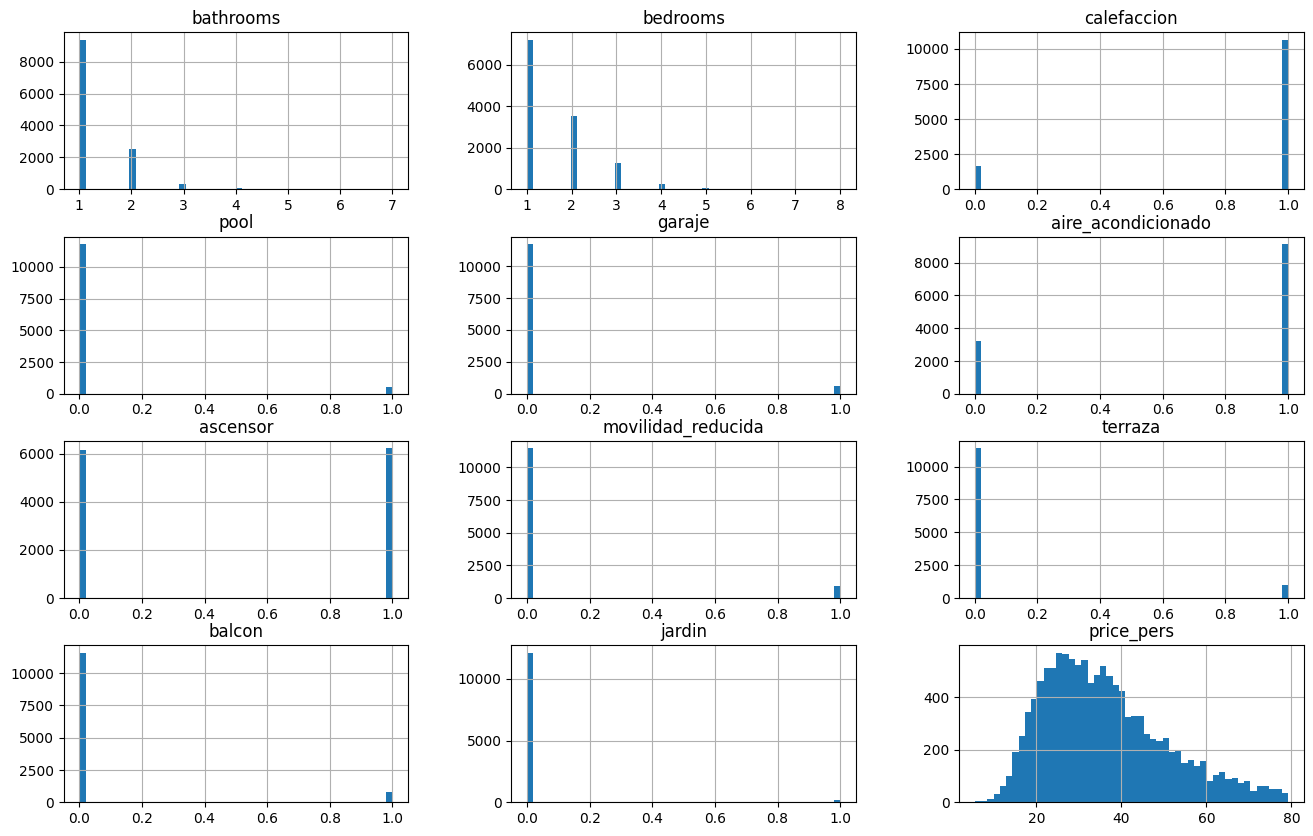

In [1281]:
#Histogram of all numeric values
dfm.hist(bins=50, figsize=(16,10))
plt.show()

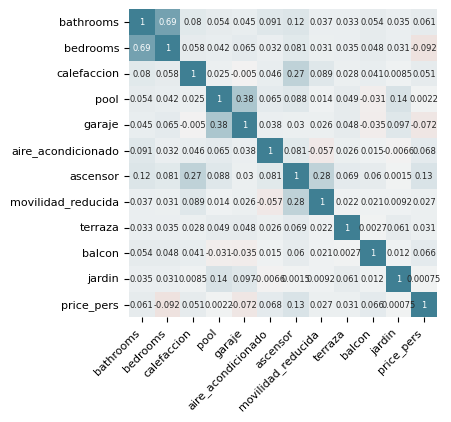

In [1282]:
import seaborn as sns

corr_matrix = dfm.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

In [1283]:
dfm.drop(columns=['bathrooms'],inplace=True)

##### Training Model

In [1284]:
target = "price_pers"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [1285]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

X_train.select_dtypes(include='object').columns

In [1286]:
numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

In [1287]:
numerical_features

Index(['bedrooms', 'calefaccion', 'pool', 'garaje', 'aire_acondicionado',
       'ascensor', 'movilidad_reducida', 'terraza', 'balcon', 'jardin'],
      dtype='object')

In [1288]:
categorical_feature

Index(['neighbourhood_group_cleansed'], dtype='object')

In [1289]:
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

model = Pipeline(steps=[
     ('preprocess', preprocessor),
     ('model', linear_model.Ridge())
 ])

In [1290]:
from sklearn.model_selection import cross_val_score

model_rmse =  cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)


In [1291]:
pd.Series(model_rmse).describe()

count    10.000000
mean    -13.518547
std       0.372751
min     -14.030452
25%     -13.825193
50%     -13.583478
75%     -13.147289
max     -13.061743
dtype: float64

In [1292]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['neighbourhood_group_cleansed'], dtype='object'))])),
                ('model', Ridge())])

In [1293]:
importances = model['model'].coef_
feature_names = model['preprocess'].get_feature_names_out()
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feature_importance)

cat__neighbourhood_group_cleansed_Salamanca                10.862073
cat__neighbourhood_group_cleansed_Chamberí                  9.200735
cat__neighbourhood_group_cleansed_Moncloa - Aravaca         7.996413
cat__neighbourhood_group_cleansed_Centro                    6.967376
cat__neighbourhood_group_cleansed_Retiro                    5.567598
remainder__pool                                             4.224840
cat__neighbourhood_group_cleansed_Chamartín                 4.016149
remainder__balcon                                           2.659210
cat__neighbourhood_group_cleansed_Tetuán                    2.526865
remainder__ascensor                                         2.375379
remainder__terraza                                          2.332696
remainder__jardin                                           1.510883
remainder__aire_acondicionado                               1.479887
remainder__garaje                                           0.738616
cat__neighbourhood_group_cleansed_

In [1294]:
#With decision Tree

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

model = Pipeline(steps=[
     ('preprocess', preprocessor),
     ('model', RandomForestRegressor(random_state=42))
 ])

In [1295]:
model.fit(X_train,y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['neighbourhood_group_cleansed'], dtype='object'))])),
                ('model', RandomForestRegressor(random_state=42))])

In [1296]:
importances = model['model'].feature_importances_
feature_names = model['preprocess'].get_feature_names_out()
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feature_importance)

remainder__bedrooms                                        0.143184
cat__neighbourhood_group_cleansed_Centro                   0.076503
remainder__aire_acondicionado                              0.070375
cat__neighbourhood_group_cleansed_Salamanca                0.069267
remainder__ascensor                                        0.065593
remainder__terraza                                         0.057709
cat__neighbourhood_group_cleansed_Chamberí                 0.055116
remainder__calefaccion                                     0.053893
remainder__pool                                            0.048816
remainder__garaje                                          0.045524
remainder__balcon                                          0.041736
remainder__movilidad_reducida                              0.037461
cat__neighbourhood_group_cleansed_Moncloa - Aravaca        0.026388
remainder__jardin                                          0.024441
cat__neighbourhood_group_cleansed_Retiro        

In [1297]:
from sklearn.model_selection import cross_val_score

model_rmse =  cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=10)

In [1298]:
pd.Series(model_rmse).describe()

count    10.000000
mean    -13.701916
std       0.421209
min     -14.321059
25%     -14.020252
50%     -13.655591
75%     -13.363662
max     -13.141274
dtype: float64

### Model 005


- Using new calculated columns ratio bath/bedrooms

In [1299]:
dfm = df.copy()

In [1300]:
dfm.shape

(12347, 25)

In [1301]:
dfm.head()

,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,price,estimated_occupancy_l365d,estimated_revenue_l365d,calefaccion,...,terraza,balcon,jardin,meters,price_pers,distance_to_center,bath_bed_ratio,renta_bin,es_centro,nearest_metro_distance
5,Centro,40.42381,-3.71038,2,1,1,66.0,0,0.0,1,...,0,1,0,NaN,33.000000,0.009614,1.000000,bajo,1,0.030983
6,Centro,40.42252,-3.70250,2,1,1,89.0,0,0.0,1,...,0,0,0,NaN,44.500000,0.005866,1.000000,bajo,1,0.272099
7,Centro,40.41150,-3.70449,6,1,3,173.0,102,17646.0,1,...,1,0,0,NaN,28.833333,0.005345,0.333333,bajo,1,0.095605
9,Centro,40.40866,-3.70374,2,1,1,72.0,0,0.0,1,...,0,0,0,NaN,36.000000,0.008140,1.000000,bajo,1,0.241036
10,Centro,40.40939,-3.69812,6,1,3,189.0,144,27216.0,1,...,1,0,0,NaN,31.500000,0.009337,0.333333,bajo,1,0.233376


In [1302]:
dfm = dfm[['price_pers','bath_bed_ratio','calefaccion','garaje','pool','aire_acondicionado','ascensor','movilidad_reducida','terraza','balcon','jardin']]

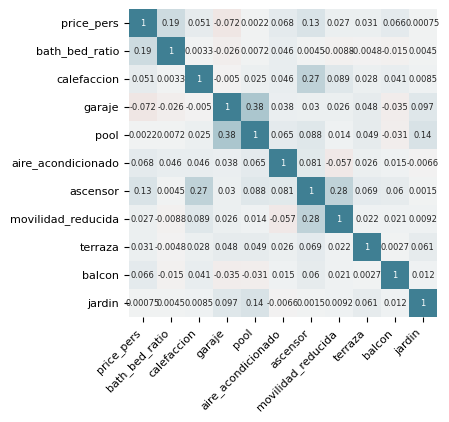

In [1303]:
import seaborn as sns

corr_matrix = dfm.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

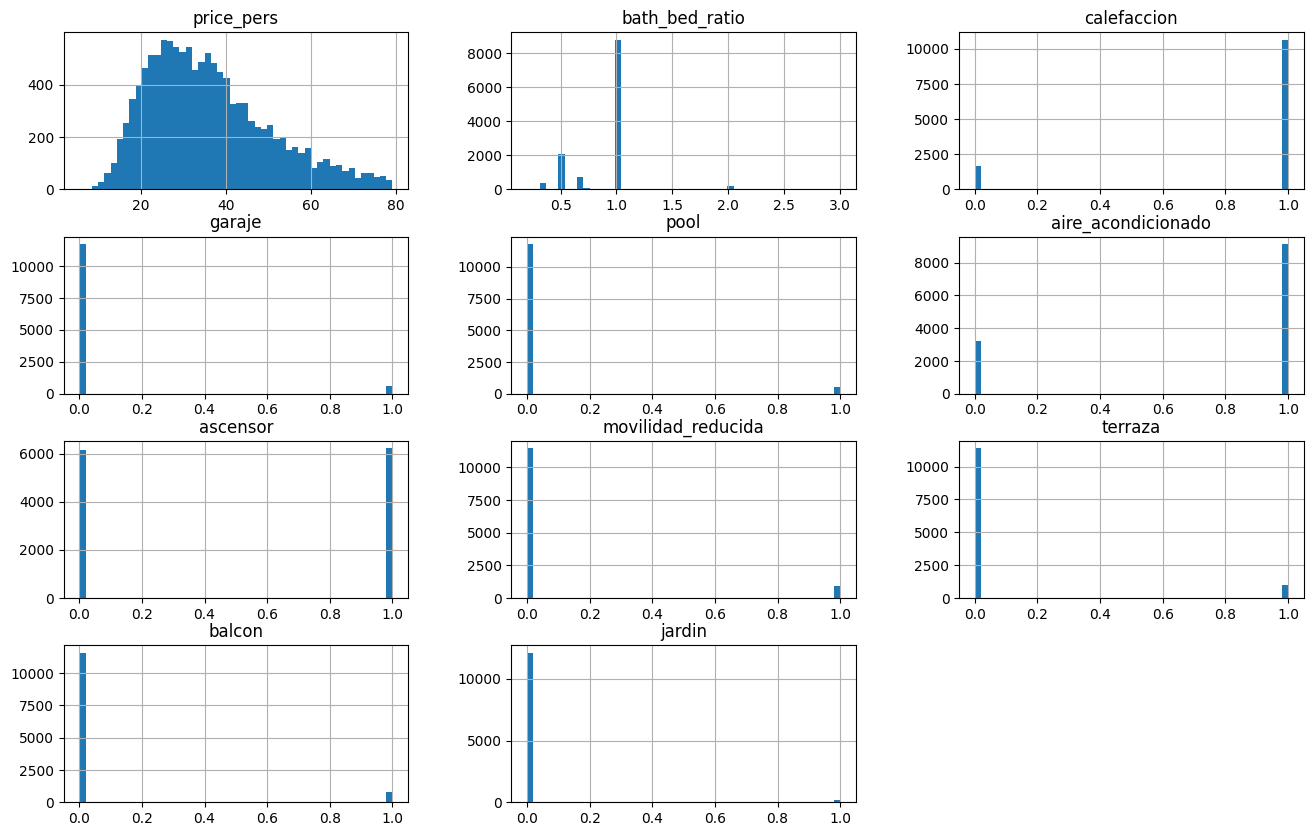

In [1304]:
#Histogram of all numeric values
dfm.hist(bins=50, figsize=(16,10))
plt.show()

##### Training Model

In [1305]:
target = "price_pers"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [1306]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

X_train.select_dtypes(include='object').columns

In [1307]:
numerical_features = ['bath_bed_ratio']
categorical_feature = X_train.select_dtypes(include='object').columns

In [1308]:
numerical_features

['bath_bed_ratio']

In [1309]:
categorical_feature

Index([], dtype='object')

In [1310]:
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')


In [1311]:
model = Pipeline(steps=[
     ('preprocess', preprocessor),
     ('model', linear_model.Ridge(random_state=42))
    ])

In [1312]:
model.fit(X_train, y_train)

importances = model['model'].coef_
feature_names = model['preprocess'].get_feature_names_out()
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feature_importance)

remainder__ascensor              3.287677
remainder__balcon                3.284148
num__bath_bed_ratio              2.674967
remainder__pool                  1.595170
remainder__terraza               1.572094
remainder__aire_acondicionado    1.493744
remainder__calefaccion           0.496683
remainder__jardin                0.234347
remainder__movilidad_reducida    0.150838
remainder__garaje               -4.835309
dtype: float64


In [1313]:
y_test_pred = model.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
r2 = metrics.r2_score(y_test, y_test_pred)
print(f"r2: {r2}  mse:{mse} rmse: {rmse} mape: {mape}")

r2: 0.07115808008410407  mse:191.52800676770556 rmse: 13.839364391752447 mape: 0.3659258761312983


In [1314]:
get_results(X_train,y_train,X_test,y_test)

100%|██████████| 7/7 [00:00<00:00,  8.83it/s]


,r2,mse,rmse,mape
lr,0.071165,191.526562,13.839312,0.365920
ridge,0.071165,191.526562,13.839312,0.365920
lasso,-0.000543,206.312858,14.363595,0.387408
SGD,0.071046,191.551021,13.840196,0.358031
HuberRegressor,0.063792,193.046967,13.894134,0.342975
Elastic,0.006637,204.832324,14.311964,0.385788
XGBRegressor,0.044968,196.928429,14.033119,0.366761


### Model 005_01


- Using new calculated columns ratio bath/bedrooms with renta_bin

In [1315]:
dfm = df.copy()

In [1316]:
dfm.shape

(12347, 25)

In [1317]:
dfm.head()

,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,price,estimated_occupancy_l365d,estimated_revenue_l365d,calefaccion,...,terraza,balcon,jardin,meters,price_pers,distance_to_center,bath_bed_ratio,renta_bin,es_centro,nearest_metro_distance
5,Centro,40.42381,-3.71038,2,1,1,66.0,0,0.0,1,...,0,1,0,NaN,33.000000,0.009614,1.000000,bajo,1,0.030983
6,Centro,40.42252,-3.70250,2,1,1,89.0,0,0.0,1,...,0,0,0,NaN,44.500000,0.005866,1.000000,bajo,1,0.272099
7,Centro,40.41150,-3.70449,6,1,3,173.0,102,17646.0,1,...,1,0,0,NaN,28.833333,0.005345,0.333333,bajo,1,0.095605
9,Centro,40.40866,-3.70374,2,1,1,72.0,0,0.0,1,...,0,0,0,NaN,36.000000,0.008140,1.000000,bajo,1,0.241036
10,Centro,40.40939,-3.69812,6,1,3,189.0,144,27216.0,1,...,1,0,0,NaN,31.500000,0.009337,0.333333,bajo,1,0.233376


In [1318]:
dfm = dfm[['price_pers','bath_bed_ratio','calefaccion','garaje','pool','aire_acondicionado','ascensor','movilidad_reducida','terraza','balcon','jardin','renta_bin']]

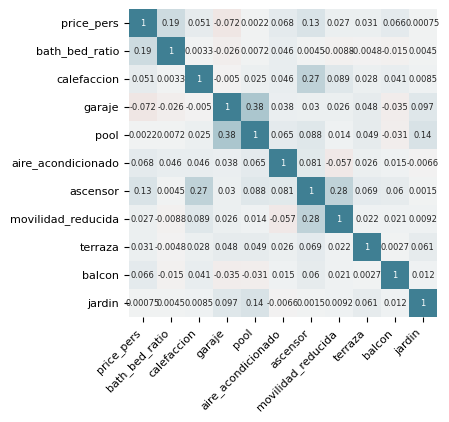

In [1319]:
import seaborn as sns

corr_matrix = dfm.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

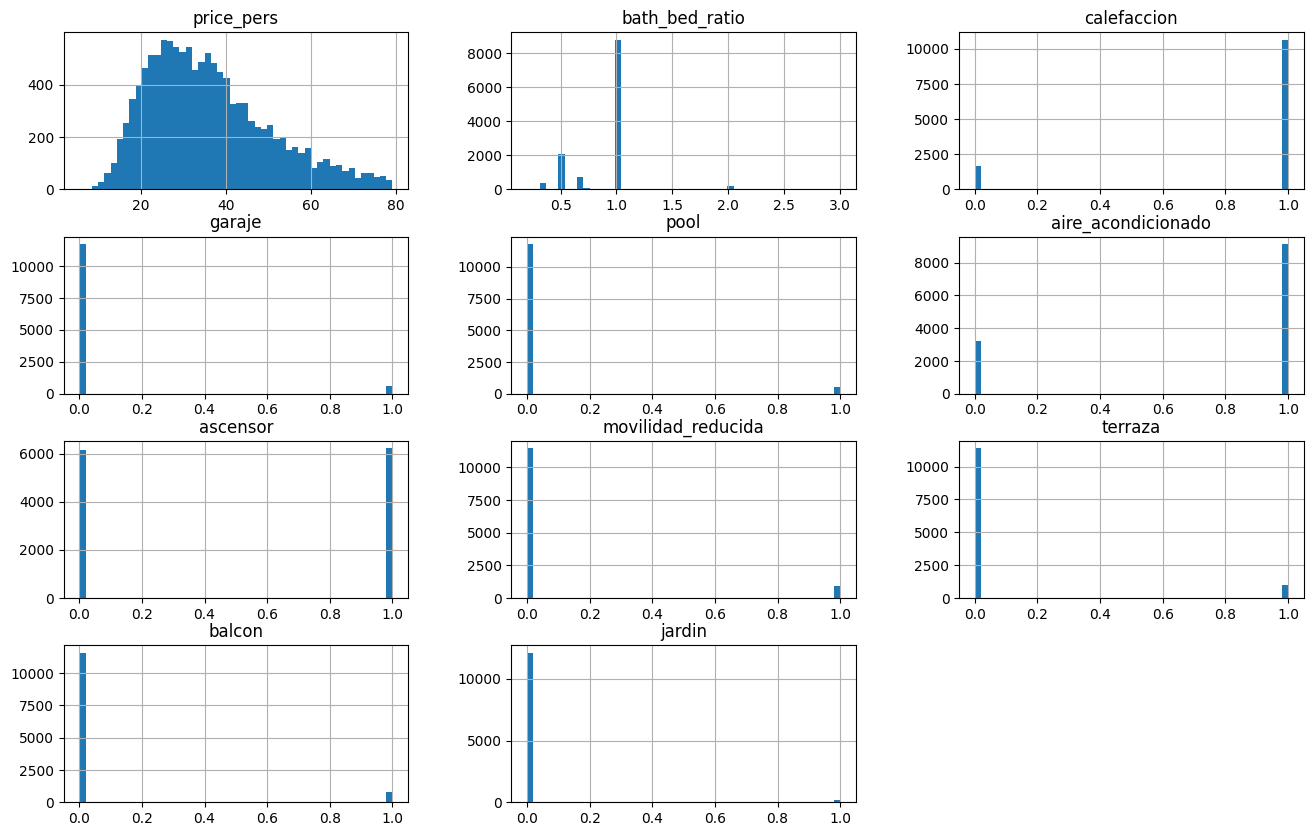

In [1320]:
#Histogram of all numeric values
dfm.hist(bins=50, figsize=(16,10))
plt.show()

##### Training Model

In [1321]:
target = "price_pers"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [1322]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

X_train.select_dtypes(include='object').columns

In [1323]:
numerical_features = ['bath_bed_ratio']
categorical_feature = X_train.select_dtypes(include='object').columns

In [1324]:
numerical_features

['bath_bed_ratio']

In [1325]:
categorical_feature

Index(['renta_bin'], dtype='object')

In [1326]:
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')


In [1327]:
model = Pipeline(steps=[
     ('preprocess', preprocessor),
     ('model', linear_model.Ridge(random_state=42))
    ])

In [1328]:
model.fit(X_train, y_train)

importances = model['model'].coef_
feature_names = model['preprocess'].get_feature_names_out()
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feature_importance)

remainder__balcon                3.169753
remainder__ascensor              2.606554
num__bath_bed_ratio              2.503533
remainder__terraza               1.801709
remainder__pool                  1.345158
remainder__aire_acondicionado    1.289577
remainder__jardin                0.514619
remainder__movilidad_reducida    0.485764
remainder__calefaccion           0.319000
cat__renta_bin_muy_alto         -2.090609
cat__renta_bin_bajo             -2.257004
remainder__garaje               -3.521110
cat__renta_bin_medio            -7.332465
cat__renta_bin_muy_bajo         -9.756349
dtype: float64


In [1329]:
y_train_pred = model.predict(X_train)
mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
r2 = metrics.r2_score(y_train, y_train_pred)
print("Train")
print(f"r2: {r2}  mse:{mse} rmse: {rmse} mape: {mape}")

Train
r2: 0.0954464286606822  mse:187.3838752671158 rmse: 13.688823005178925 mape: 0.35349192929745954


In [1330]:
y_test_pred = model.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
r2 = metrics.r2_score(y_test, y_test_pred)
print("Test")
print(f"r2: {r2}  mse:{mse} rmse: {rmse} mape: {mape}")

Test
r2: 0.09410628395607168  mse:186.7960672931232 rmse: 13.667335778897188 mape: 0.35923065390537867


In [1331]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
get_results(X_train_preprocessed,y_train,X_test_preprocessed,y_test)

100%|██████████| 7/7 [00:00<00:00,  7.51it/s]


,r2,mse,rmse,mape
lr,0.094065,186.804621,13.667649,0.359234
ridge,0.094065,186.804621,13.667649,0.359234
lasso,0.032772,199.443261,14.122438,0.378085
SGD,0.094611,186.691925,13.663525,0.358064
HuberRegressor,0.086630,188.337694,13.723618,0.337669
Elastic,0.036518,198.670733,14.095061,0.377539
XGBRegressor,0.077171,190.288231,13.794500,0.356471


### Model 006

Añadimos distancia al centro

In [1332]:
dfm = df.copy()

In [1333]:
dfm.dtypes

neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
accommodates                      int64
bathrooms                         int64
bedrooms                          int64
price                           float64
estimated_occupancy_l365d         int64
estimated_revenue_l365d         float64
calefaccion                       int64
pool                              int64
garaje                            int64
aire_acondicionado                int64
ascensor                          int64
movilidad_reducida                int64
terraza                           int64
balcon                            int64
jardin                            int64
meters                          float64
price_pers                      float64
distance_to_center              float64
bath_bed_ratio                  float64
renta_bin                        object
es_centro                         int64
nearest_metro_distance          float64


In [1334]:
dfm.shape

(12347, 25)

In [1335]:
dfm = dfm[['distance_to_center','bedrooms','price','calefaccion','aire_acondicionado','ascensor','movilidad_reducida','terraza','balcon','pool','garaje','jardin']]

In [1336]:
dfm.dtypes

distance_to_center    float64
bedrooms                int64
price                 float64
calefaccion             int64
aire_acondicionado      int64
ascensor                int64
movilidad_reducida      int64
terraza                 int64
balcon                  int64
pool                    int64
garaje                  int64
jardin                  int64
dtype: object

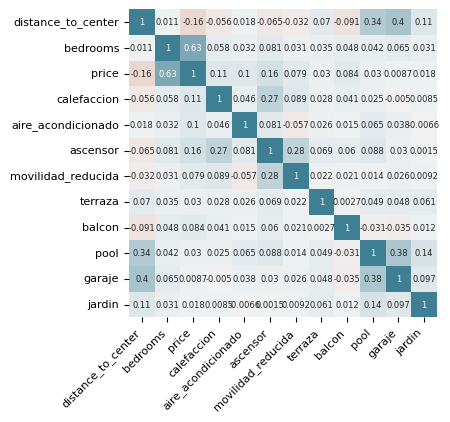

In [1337]:
import seaborn as sns

corr_matrix = dfm.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

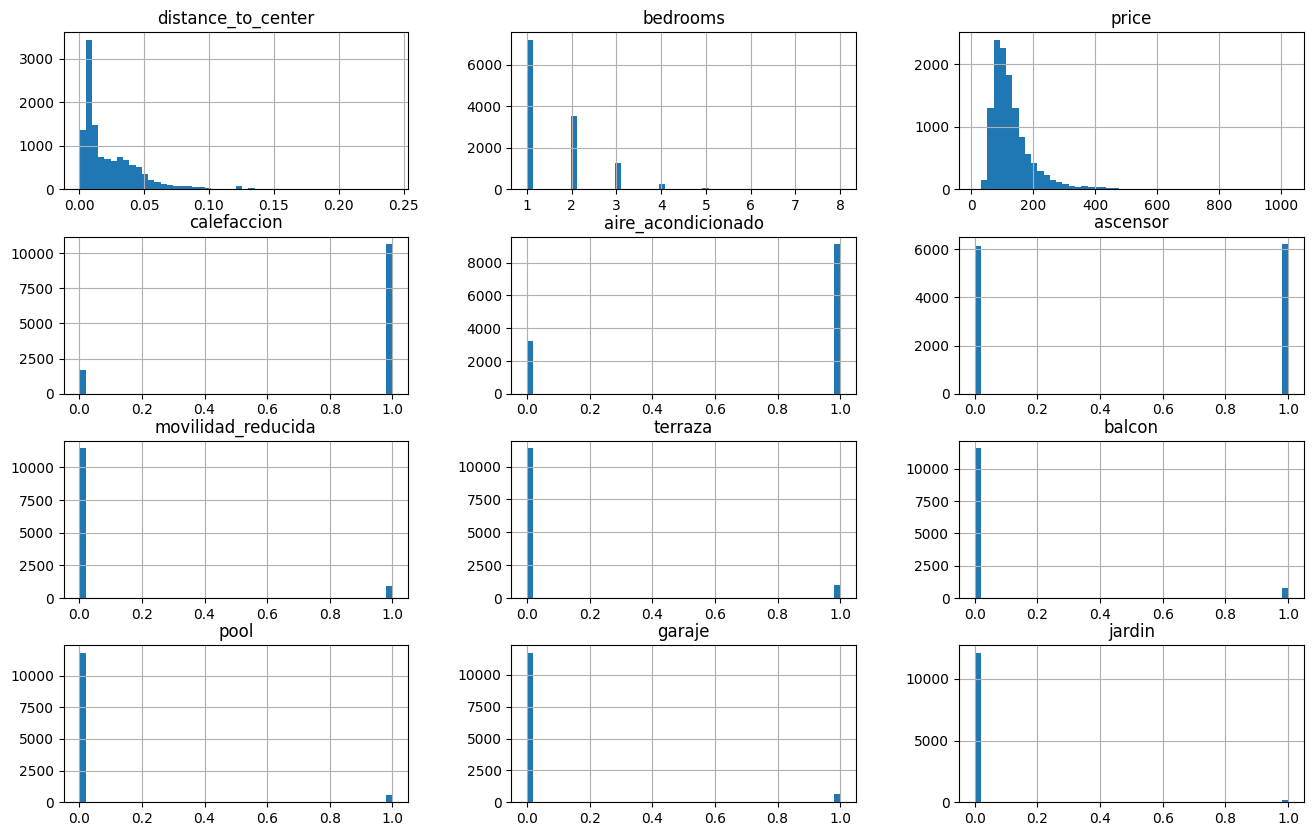

In [1338]:
#Histogram of all numeric values
dfm.hist(bins=50, figsize=(16,10))
plt.show()

In [1339]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [1340]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

In [1341]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

In [1342]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [1343]:
model = linear_model.LinearRegression()
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})

In [1344]:
test_predict_analysis = test_predict_analysis.sort_values("y")
train_predict_analysis = train_predict_analysis.sort_values("y")

In [1345]:
train_predict_analysis.head(20)

,y,y_pred
17004,11.0,89.634030
22507,12.0,88.338755
23067,29.0,63.696128
6676,30.0,122.819827
16851,34.0,109.795101
562,35.0,110.814953
10228,35.0,94.534117
24254,36.0,158.549717
17607,37.0,55.205462
6493,37.0,105.068920


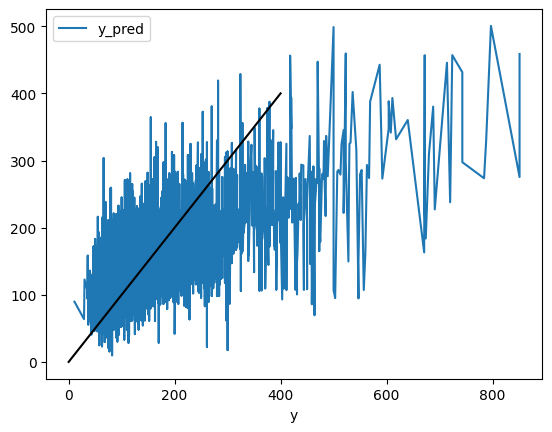

In [1346]:
train_predict_analysis.plot.line(x="y",y="y_pred")
plt.plot((0,400),(0,400),c="k")

En el grafico se esta viendo que por ejemplo para una casa de 50 estamos dando una prediccion de 100 a 150

In [1347]:
train_predict_analysis["y_pred_diff"]=train_predict_analysis["y_pred"]-train_predict_analysis["y"]

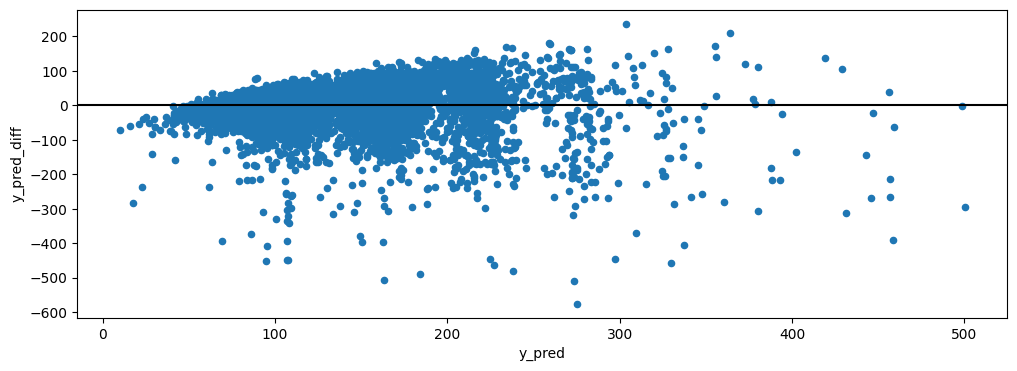

In [1348]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")

<Axes: ylabel='Frequency'>

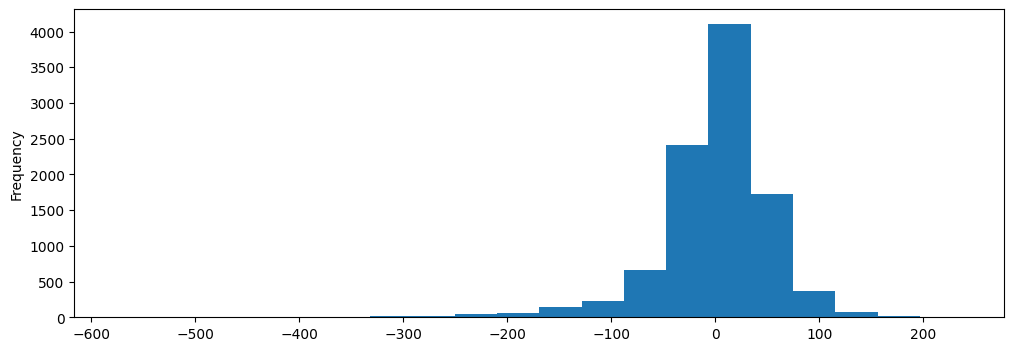

In [1349]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis["y_pred_diff"].plot.hist(bins=20)

In [1350]:
num_features = numerical_features.tolist()

# Extract names from one-hot encoded categorical features
# cat_encoder = preprocessor.named_transformers_['cat']
# cat_feature_names = cat_encoder.get_feature_names_out(categorical_feature)

# Combine all names
feature_names = num_features #+ list(cat_feature_names)

# 6. Create a DataFrame with coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', key=np.abs, ascending=False)

# 7. Show top features
print(coef_df)

               Feature  Coefficient
1             bedrooms    45.895857
0   distance_to_center   -14.063620
3   aire_acondicionado     5.608962
4             ascensor     4.652068
8                 pool     3.631527
5   movilidad_reducida     2.760878
7               balcon     2.698631
2          calefaccion     2.573777
9               garaje     1.593622
6              terraza     0.649635
10              jardin     0.611272


In [1351]:
get_results(X_train, y_train, X_test, y_test)

100%|██████████| 7/7 [00:00<00:00,  8.55it/s]


,r2,mse,rmse,mape
lr,0.464056,3099.541980,55.673530,0.310282
ridge,0.464056,3099.541980,55.673530,0.310282
lasso,0.462881,3106.339269,55.734543,0.308952
SGD,0.461814,3112.508488,55.789860,0.308842
HuberRegressor,0.441622,3229.286837,56.826814,0.282045
Elastic,0.409248,3416.516526,58.450975,0.322315
XGBRegressor,0.458278,3132.960575,55.972856,0.302546


### Model 007

renta_bin y distance_center y considerando otros outliers en precio

In [1352]:
dfm = df.copy()

In [1353]:
dfm.dtypes

neighbourhood_group_cleansed     object
latitude                        float64
longitude                       float64
accommodates                      int64
bathrooms                         int64
bedrooms                          int64
price                           float64
estimated_occupancy_l365d         int64
estimated_revenue_l365d         float64
calefaccion                       int64
pool                              int64
garaje                            int64
aire_acondicionado                int64
ascensor                          int64
movilidad_reducida                int64
terraza                           int64
balcon                            int64
jardin                            int64
meters                          float64
price_pers                      float64
distance_to_center              float64
bath_bed_ratio                  float64
renta_bin                        object
es_centro                         int64
nearest_metro_distance          float64


In [1354]:
dfm.shape

(12347, 25)

In [1355]:
dfm = dfm[['bedrooms','accommodates','bathrooms','price','renta_bin','garaje','ascensor','pool','terraza','balcon','distance_to_center','aire_acondicionado','movilidad_reducida','jardin']]

In [1356]:
dfm.dtypes

bedrooms                int64
accommodates            int64
bathrooms               int64
price                 float64
renta_bin              object
garaje                  int64
ascensor                int64
pool                    int64
terraza                 int64
balcon                  int64
distance_to_center    float64
aire_acondicionado      int64
movilidad_reducida      int64
jardin                  int64
dtype: object

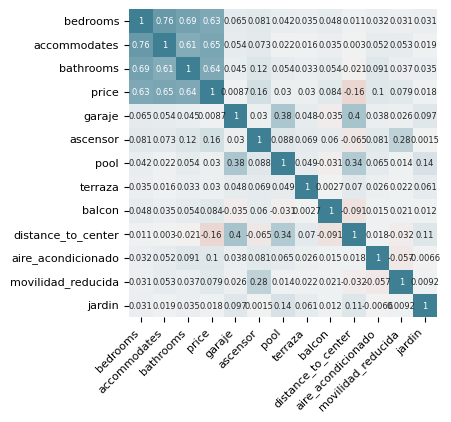

In [1357]:
import seaborn as sns

corr_matrix = dfm.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

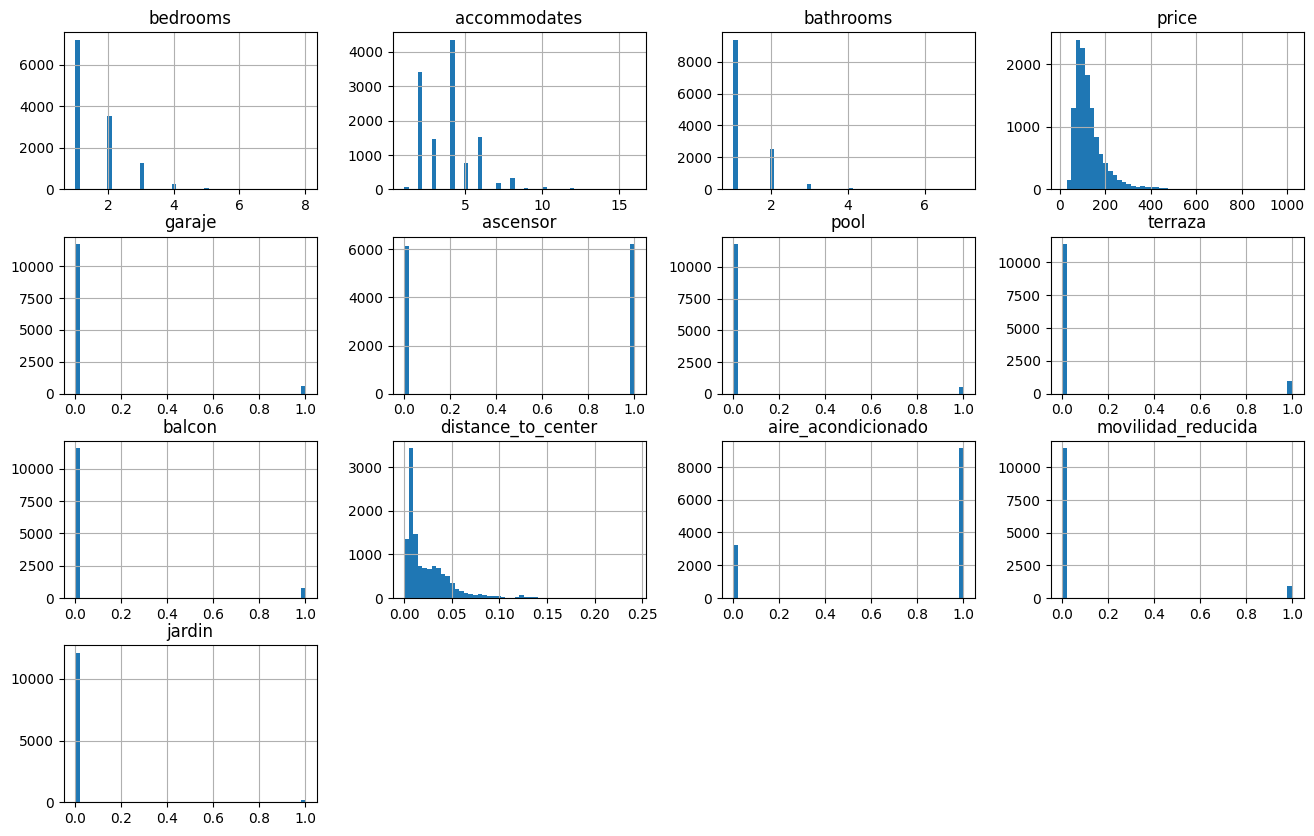

In [1358]:
#Histogram of all numeric values
dfm.hist(bins=50, figsize=(16,10))
plt.show()

In [1359]:
dfm.shape

(12347, 14)

In [1360]:
from scipy.stats import zscore
data = np.array(dfm["price"])
z_scores = zscore(data)
z_scores

array([-0.8734162 , -0.5702148 ,  0.53712947, ..., -0.38565742,
       -0.42520543, -0.8734162 ])

In [1361]:
outliers = data[np.abs(z_scores) > 3]
print("Outliers:", outliers)

Outliers: [ 385.  375.  444.  884.  363.  456.  361.  418.  672.  507.  371.  396.
  455.  543.  618.  457.  399.  571.  391.  482.  404.  486.  379.  720.
  500.  851.  388.  370.  513.  416.  402.  509.  608.  364.  485.  604.
  515.  409.  475.  448.  523.  604.  415.  372.  587.  447.  470.  438.
  552.  397.  363.  399.  381.  365.  458.  366.  724.  429.  422.  399.
  389.  391.  465.  597.  411.  380.  375.  392.  691.  368.  672.  571.
  462.  569.  392.  547.  592.  375.  363.  418.  407.  361.  360.  392.
  361. 1021.  384.  450.  468.  406.  743.  500.  383.  361.  364.  391.
  382.  364.  373.  453.  398.  434.  489.  439.  360.  386.  420.  606.
  529.  429.  563.  465.  498.  519.  393.  377.  376.  473.  380.  407.
  379.  743.  438.  392.  414.  567.  528.  425.  611.  523.  462.  602.
  474.  375.  560.  400.  395.  688.  386.  392.  422.  503.  547.  363.
  478.  411.  680.  394.  450.  473.  384.  360.  456.  460.  362.  398.
  436.  360.  429.  429.  429.  389.  851

In [1362]:
dfm = dfm[~dfm['price'].isin(outliers)]
dfm.shape

(12078, 14)

{'whiskers': [<matplotlib.lines.Line2D at 0x322182410>,
 'caps': [<matplotlib.lines.Line2D at 0x328052710>,
 'boxes': [<matplotlib.lines.Line2D at 0x3336a7690>],
 'medians': [<matplotlib.lines.Line2D at 0x328052410>],
 'fliers': [<matplotlib.lines.Line2D at 0x32a3d8d10>],
 'means': []}

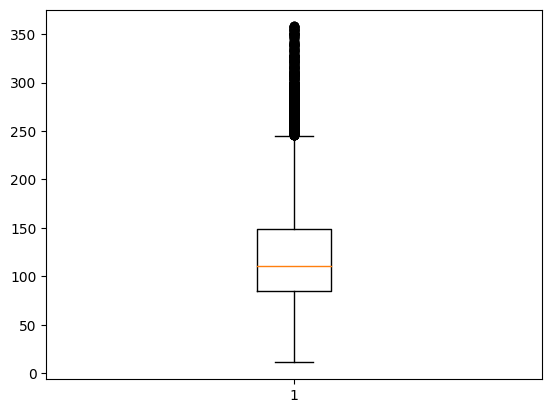

In [1363]:
plt.boxplot(dfm["price"])

In [1364]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [1365]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

In [1366]:


numerical_features = ['bedrooms','bathrooms','distance_to_center']#X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

In [1367]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [1368]:
model = linear_model.Ridge(alpha=9.3)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)

In [1369]:
mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
r2 = metrics.r2_score(y_train, y_train_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4960756126808208 mse: 1576.7772361252332 rmse: 39.70865442350362 mape: 0.2536735320177359


In [1370]:
# # Extract names from one-hot encoded categorical features
# num_features = ['bedrooms','bathrooms','accommodates','garaje','ascensor','aire_acondicionado','pool','terraza','balcon']
# cat_encoder = preprocessor.named_transformers_['cat']
# cat_feature_names = cat_encoder.get_feature_names_out(categorical_feature)


# # Combine all names
# feature_names = num_features + list(cat_feature_names)

# # 6. Create a DataFrame with coefficients
# coef_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Coefficient': model.coef_
# }).sort_values(by='Coefficient', key=np.abs, ascending=False)

# # 7. Show top features
# print(coef_df)

In [1371]:
cv_scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-39.61905848 -40.41265915 -38.63093588 -40.0592004  -40.2412716 ]
Média métricas de validación cruzada: -39.792625101456494


In [1372]:
# param_grid = {'alpha': [9.3],
#               'epsilon': np.arange(1,1.35,0.01)}
# model = linear_model.HuberRegressor()
# # Búsqueda por validación cruzada
# grid = GridSearchCV(
#         estimator  = model,
#         param_grid = param_grid,
#         scoring    = 'neg_root_mean_squared_error',
#         n_jobs     = -1,
#         cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
#         # verbose    = 0,
#         return_train_score = True
#     )

# grid.fit(X = X_train, y = y_train)

# # Resultados del grid
# resultados = pd.DataFrame(grid.cv_results_)
# resultados.filter(regex = '(param.*|mean_t|std_t)')\
#     .drop(columns = 'params')\
#     .sort_values('mean_test_score', ascending = False)

In [1373]:
get_results(X_train, y_train, X_test, y_test)

100%|██████████| 7/7 [00:00<00:00,  7.67it/s]


,r2,mse,rmse,mape
lr,0.484806,1633.578054,40.417546,0.253995
ridge,0.484806,1633.578054,40.417546,0.253995
lasso,0.469220,1682.999156,41.024373,0.259687
SGD,0.483151,1638.826494,40.482422,0.266828
HuberRegressor,0.473721,1668.726385,40.850048,0.242373
Elastic,0.441942,1769.491300,42.065322,0.270827
XGBRegressor,0.516450,1533.242252,39.156637,0.240998


### Model 008

In [1374]:
dfm = df.copy()

In [1375]:
dfm.shape

(12347, 25)

In [1376]:
#'jardin','garaje'
dfm = dfm[['bedrooms','accommodates','bathrooms','price','renta_bin','ascensor','pool','terraza','balcon','distance_to_center','aire_acondicionado','movilidad_reducida','calefaccion']]

In [1377]:
from scipy.stats import zscore
data = np.array(dfm["price"])
z_scores = zscore(data)
z_scores

array([-0.8734162 , -0.5702148 ,  0.53712947, ..., -0.38565742,
       -0.42520543, -0.8734162 ])

In [1378]:
outliers = data[np.abs(z_scores) > 3]
print("Outliers:", outliers)

Outliers: [ 385.  375.  444.  884.  363.  456.  361.  418.  672.  507.  371.  396.
  455.  543.  618.  457.  399.  571.  391.  482.  404.  486.  379.  720.
  500.  851.  388.  370.  513.  416.  402.  509.  608.  364.  485.  604.
  515.  409.  475.  448.  523.  604.  415.  372.  587.  447.  470.  438.
  552.  397.  363.  399.  381.  365.  458.  366.  724.  429.  422.  399.
  389.  391.  465.  597.  411.  380.  375.  392.  691.  368.  672.  571.
  462.  569.  392.  547.  592.  375.  363.  418.  407.  361.  360.  392.
  361. 1021.  384.  450.  468.  406.  743.  500.  383.  361.  364.  391.
  382.  364.  373.  453.  398.  434.  489.  439.  360.  386.  420.  606.
  529.  429.  563.  465.  498.  519.  393.  377.  376.  473.  380.  407.
  379.  743.  438.  392.  414.  567.  528.  425.  611.  523.  462.  602.
  474.  375.  560.  400.  395.  688.  386.  392.  422.  503.  547.  363.
  478.  411.  680.  394.  450.  473.  384.  360.  456.  460.  362.  398.
  436.  360.  429.  429.  429.  389.  851

In [1379]:
dfm = dfm[~dfm['price'].isin(outliers)]
dfm.shape

(12078, 13)

In [1380]:
dfm.dtypes

bedrooms                int64
accommodates            int64
bathrooms               int64
price                 float64
renta_bin              object
ascensor                int64
pool                    int64
terraza                 int64
balcon                  int64
distance_to_center    float64
aire_acondicionado      int64
movilidad_reducida      int64
calefaccion             int64
dtype: object

In [1381]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [1382]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

In [1383]:


numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

In [1384]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [1385]:
model = XGBRegressor()
reg_cv = GridSearchCV(model, {"colsample_bytree":[1.0],"min_child_weight":[1.0,1.2]
                            ,'max_depth': [3,4,6], 'n_estimators': [500,1000]}, verbose=1)
reg_cv.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [1.0], 'max_depth': [3, 4, 6],
                         'min_child_weight': [1.0, 1.2],
                         'n_estimators': [500, 1000]},
             verbose=1)

In [1386]:
reg_cv.best_params_

{'colsample_bytree': 1.0,
 'max_depth': 3,
 'min_child_weight': 1.2,
 'n_estimators': 500}

In [1387]:
model = XGBRegressor(**reg_cv.best_params_)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)

In [1388]:

num_features = numerical_features.tolist()

# Extract names from one-hot encoded categorical features
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_feature)

# Combine all names
feature_names = num_features + list(cat_feature_names)


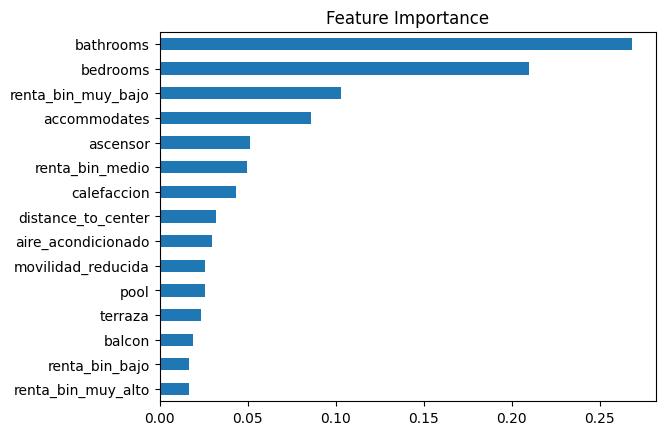

In [1389]:
feature_importance = pd.Series(model.feature_importances_, index=feature_names)
feature_importance.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.show()

In [1390]:
mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
r2 = metrics.r2_score(y_train, y_train_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.6389803876346187 mse: 1129.628811181021 rmse: 33.60995107376714 mape: 0.21763036911625944


In [1391]:
cv_scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-40.08775571 -40.38564663 -37.89774068 -40.11096266 -40.20193458]
Média métricas de validación cruzada: -39.73680805000868


In [1392]:
y_test_pred = model.predict(X_test)
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})

In [1393]:
mse = metrics.mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
r2 = metrics.r2_score(y_test, y_test_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.5248064431569127 mse: 1506.7455786266535 rmse: 38.81682082070418 mape: 0.24132518365535566


In [1394]:
train_predict_analysis.head(20)

,y,y_pred
24461,103.0,91.048584
14899,105.0,149.849335
24069,58.0,80.982719
7775,82.0,100.844696
13945,131.0,147.468719
3746,70.0,86.652939
11840,126.0,119.819412
16504,153.0,137.156982
9820,96.0,129.161118
12778,205.0,124.727745


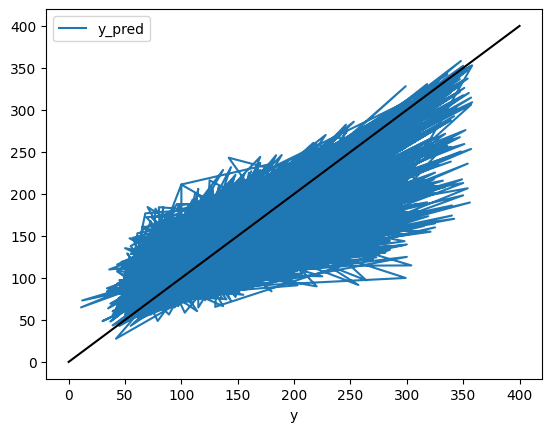

In [1395]:
train_predict_analysis.plot.line(x="y",y="y_pred")
plt.plot((0,400),(0,400),c="k")

In [1396]:
train_predict_analysis["y_pred_diff"]=train_predict_analysis["y_pred"]-train_predict_analysis["y"]

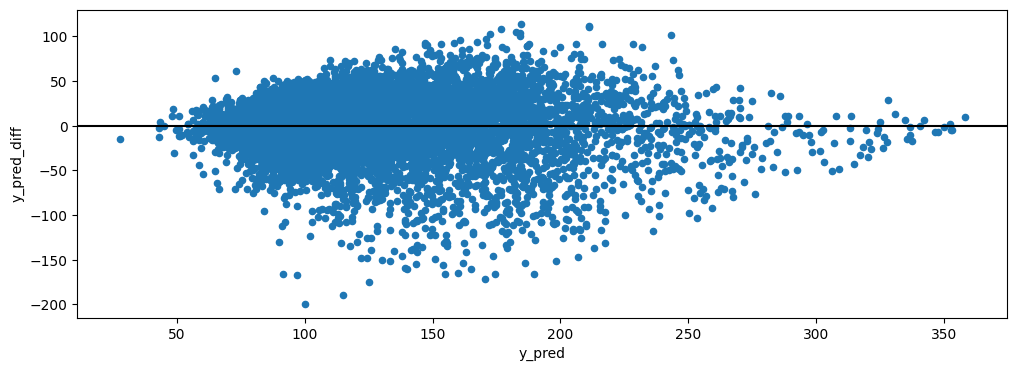

In [1397]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")

<Axes: ylabel='Frequency'>

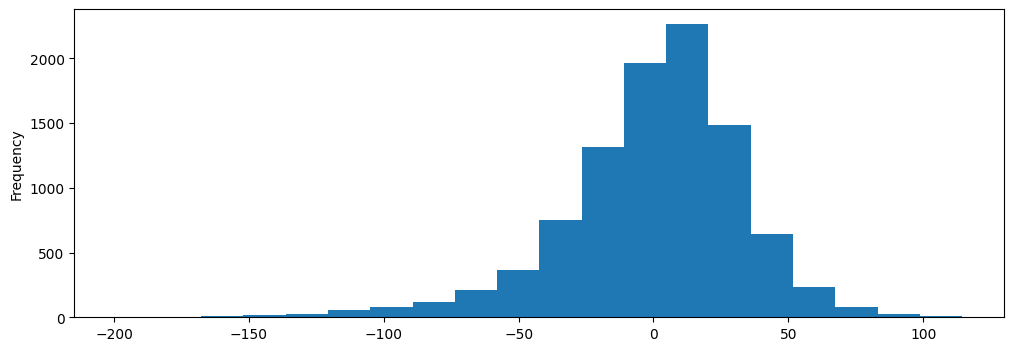

In [1398]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis["y_pred_diff"].plot.hist(bins=20)

### Model 009

Mismo modelo que Model008 pero añadiendo la columna distancia a estacion del metro y modelo SVR


In [1448]:
dfm = df.copy()

In [1449]:
dfm.shape

(12347, 25)

In [1450]:
#'jardin','garaje'
dfm = dfm[['bedrooms','accommodates','bathrooms','price','renta_bin','ascensor','pool','terraza','balcon','distance_to_center','aire_acondicionado','movilidad_reducida','calefaccion','nearest_metro_distance']]

In [1451]:
from scipy.stats import zscore
data = np.array(dfm["price"])
z_scores = zscore(data)
z_scores

array([-0.8734162 , -0.5702148 ,  0.53712947, ..., -0.38565742,
       -0.42520543, -0.8734162 ])

In [1452]:
outliers = data[np.abs(z_scores) > 3]
print("Outliers:", outliers)

Outliers: [ 385.  375.  444.  884.  363.  456.  361.  418.  672.  507.  371.  396.
  455.  543.  618.  457.  399.  571.  391.  482.  404.  486.  379.  720.
  500.  851.  388.  370.  513.  416.  402.  509.  608.  364.  485.  604.
  515.  409.  475.  448.  523.  604.  415.  372.  587.  447.  470.  438.
  552.  397.  363.  399.  381.  365.  458.  366.  724.  429.  422.  399.
  389.  391.  465.  597.  411.  380.  375.  392.  691.  368.  672.  571.
  462.  569.  392.  547.  592.  375.  363.  418.  407.  361.  360.  392.
  361. 1021.  384.  450.  468.  406.  743.  500.  383.  361.  364.  391.
  382.  364.  373.  453.  398.  434.  489.  439.  360.  386.  420.  606.
  529.  429.  563.  465.  498.  519.  393.  377.  376.  473.  380.  407.
  379.  743.  438.  392.  414.  567.  528.  425.  611.  523.  462.  602.
  474.  375.  560.  400.  395.  688.  386.  392.  422.  503.  547.  363.
  478.  411.  680.  394.  450.  473.  384.  360.  456.  460.  362.  398.
  436.  360.  429.  429.  429.  389.  851

In [1453]:
dfm = dfm[~dfm['price'].isin(outliers)]
dfm.shape

(12078, 14)

In [1454]:
dfm.dtypes

bedrooms                    int64
accommodates                int64
bathrooms                   int64
price                     float64
renta_bin                  object
ascensor                    int64
pool                        int64
terraza                     int64
balcon                      int64
distance_to_center        float64
aire_acondicionado          int64
movilidad_reducida          int64
calefaccion                 int64
nearest_metro_distance    float64
dtype: object

In [1455]:
target = "price"
y,X =dfm[target], dfm.drop(target,axis="columns")

In [1456]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size= 0.20, random_state=42)

In [1457]:


numerical_features = X_train.select_dtypes(exclude='object').columns
categorical_feature = X_train.select_dtypes(include='object').columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(drop='first'), categorical_feature)
], remainder='passthrough')

In [1458]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [1459]:
get_results(X_train, y_train, X_test, y_test)

100%|██████████| 7/7 [00:00<00:00,  8.45it/s]


,r2,mse,rmse,mape
lr,0.483897,1636.461750,40.453204,0.254410
ridge,0.483897,1636.461750,40.453204,0.254410
lasso,0.473672,1668.881694,40.851948,0.257957
SGD,0.482500,1640.889476,40.507894,0.254774
HuberRegressor,0.472778,1671.718543,40.886655,0.242682
Elastic,0.449677,1744.965652,41.772786,0.269348
XGBRegressor,0.496507,1596.476035,39.955926,0.248419


In [1460]:
from sklearn.svm import SVR
#model = SVR(kernel='rbf', C=1.0, epsilon=0.1,gamma=0.1)
model = SVR(kernel='linear', C=1.0, epsilon=0.1)
#reg_cv = GridSearchCV(model, {"C":[0.1,1.0,10.0],"epsilon":[0.1,0.2,0.3],"gamma":[0.1,0.2,0.3]}, verbose=1)
reg_cv = GridSearchCV(model, {"C":[0.1,1.0,10.0],"epsilon":[0.1,0.2,0.3]}, verbose=1)
reg_cv.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=SVR(kernel='linear'),
             param_grid={'C': [0.1, 1.0, 10.0], 'epsilon': [0.1, 0.2, 0.3]},
             verbose=1)

In [1461]:
reg_cv.best_params_

{'C': 10.0, 'epsilon': 0.2}

In [1462]:
model = SVR(**reg_cv.best_params_)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)

In [1463]:

num_features = numerical_features.tolist()

# Extract names from one-hot encoded categorical features
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_feature)

# Combine all names
feature_names = num_features + list(cat_feature_names)


In [1464]:
mse = metrics.mean_squared_error(y_train, y_train_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_train, y_train_pred)
r2 = metrics.r2_score(y_train, y_train_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.5087211926180526 mse: 1537.2092710011327 rmse: 39.20726043733651 mape: 0.22530742009763155


In [1466]:
cv_scores = cross_val_score(
                estimator = model,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
            )

print(f"Métricas validación cruzada: {cv_scores}")
print(f"Média métricas de validación cruzada: {cv_scores.mean()}")

Métricas validación cruzada: [-40.20964853 -40.90428899 -39.63691999 -39.90310874 -41.07814054]
Média métricas de validación cruzada: -40.34642135802114


In [1467]:
y_test_pred = model.predict(X_test)
test_predict_analysis =pd.DataFrame({"y":y_test,"y_pred":y_test_pred})
train_predict_analysis =pd.DataFrame({"y":y_train,"y_pred":y_train_pred})

In [1468]:
mse = metrics.mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
mape = metrics.mean_absolute_percentage_error(y_test, y_test_pred)
r2 = metrics.r2_score(y_test, y_test_pred)
print(f"r2: {r2} mse: {mse} rmse: {rmse} mape: {mape}")

r2: 0.4804051879421467 mse: 1647.5332513905198 rmse: 40.589817089887454 mape: 0.23296305354207808


In [1469]:
train_predict_analysis.head(20)

,y,y_pred
24461,103.0,74.904959
14899,105.0,157.188322
24069,58.0,101.725010
7775,82.0,96.785314
13945,131.0,137.823377
3746,70.0,87.730139
11840,126.0,108.671462
16504,153.0,132.181040
9820,96.0,137.369348
12778,205.0,109.495393


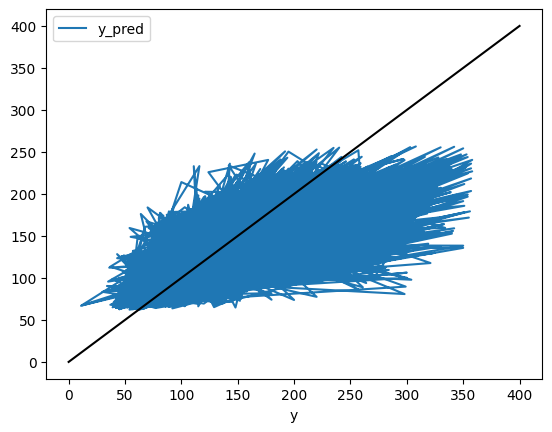

In [1470]:
train_predict_analysis.plot.line(x="y",y="y_pred")
plt.plot((0,400),(0,400),c="k")

In [1471]:
train_predict_analysis["y_pred_diff"]=train_predict_analysis["y_pred"]-train_predict_analysis["y"]

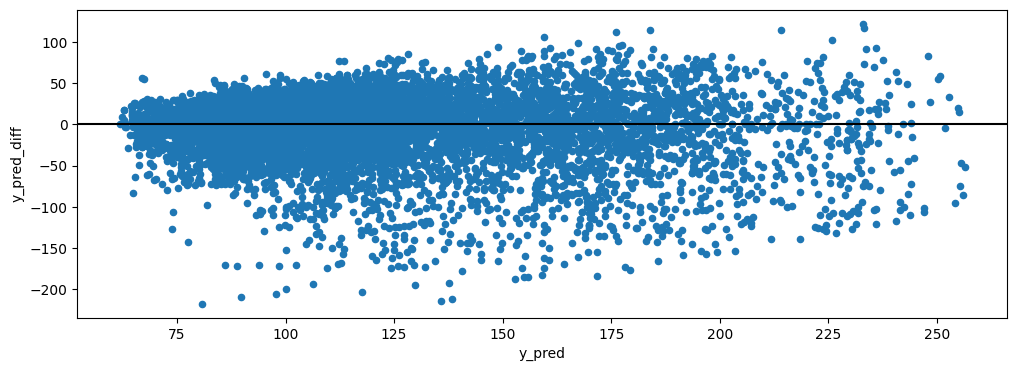

In [1472]:
_,ax = plt.subplots(figsize=(12,4))
train_predict_analysis.plot.scatter(x="y_pred",y="y_pred_diff",ax=ax)
plt.axhline(0,c="k")